import advanced_lane_detection
import matplotlib.image as mpimg
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

#### Functions that are used as part of the Vehicle Detection and Tracking lesson exercise

In [1]:
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import advanced_lane_detection


%matplotlib qt
%matplotlib inline
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

'''
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
'''

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel=0):
    b_boxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop, xstart:xstop, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else: 
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                b_boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw), int(ytop_draw+win_draw+ystart))))
    return draw_img, b_boxes

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


#### Read images for training

17760
8792 8968
data/non-vehicles/GTI/image45.png


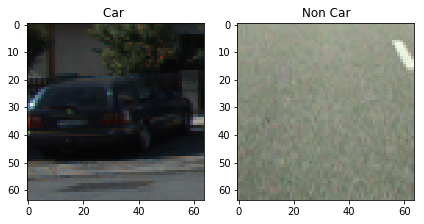

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
%matplotlib inline
# Read in cars and notcars
#images = glob.glob('*.jpeg')
images = glob.glob('data/*/*/*.png')
print (len(images))
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
        

print(len(cars), len(notcars))
print(notcars[0])

# Show car and non car images 
car_img_name = cars[random.randint(0, len(cars)-1)]
non_car_img_name = notcars[random.randint(0, len(notcars)-1)]
car_img = mpimg.imread(car_img_name)
non_car_img = mpimg.imread(non_car_img_name)
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_img)
plt.title('Car ')
plt.subplot(122)
plt.imshow(non_car_img)
plt.title('Non Car')
fig.tight_layout()

##### Display HOG features

/home/ramesh/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


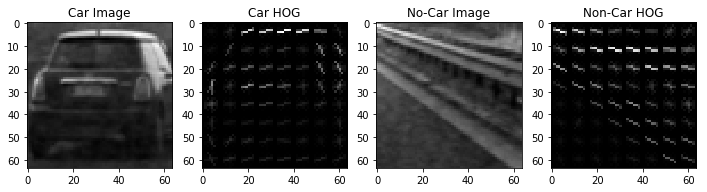

In [3]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Generate a random index to look at a car image
ind = np.random.randint(0, len(notcars))
# Read in the image
image_n = mpimg.imread(notcars[ind])
gray_n = cv2.cvtColor(image_n, cv2.COLOR_RGB2GRAY)
features_n, hog_image_n = get_hog_features(gray_n, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)



# Plot the examples
fig = plt.figure(figsize=(12,4))
plt.subplot(141)
plt.imshow(image[:,:,0], cmap='gray')
plt.title('Car Image')
plt.subplot(142)
plt.imshow(hog_image, cmap='gray')
plt.title('Car HOG')
plt.subplot(143)
plt.imshow(image_n[:,:,0], cmap='gray')
plt.title('No-Car Image')
plt.subplot(144)
plt.imshow(hog_image_n, cmap='gray')
plt.title('Non-Car HOG')

#### Training the model

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
%matplotlib inline

#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split


# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))




/home/ramesh/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ramesh/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2628
5.91 Seconds to train SVC...
Test Accuracy of SVC =  0.9761


##### Observations on the classifier training
orientation = 9 is chosen as per the working of Dalal et al work for pedstrain detection https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
spatial size of 16x16 chosen so as to not have too many svm params (so that they are not overfit the model - when 32x32 size is taken)


#### Test Sliding window/Search Window functions based on the trained SVC classfieer

/home/ramesh/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


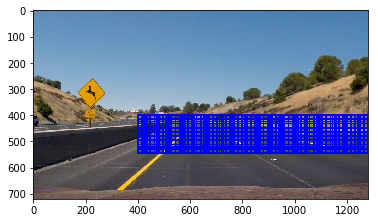

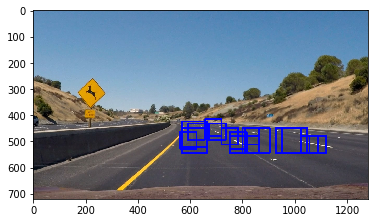

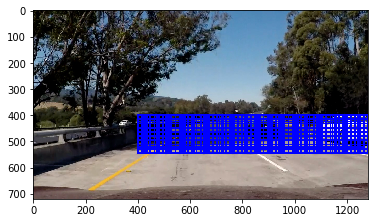

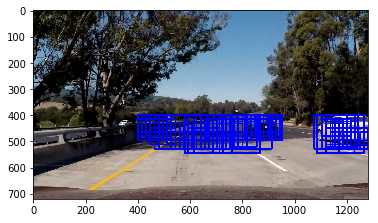

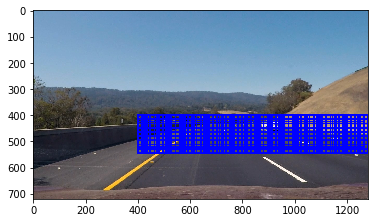

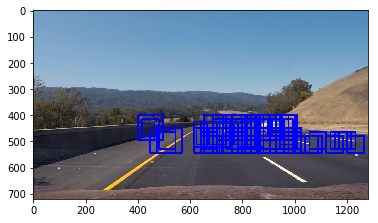

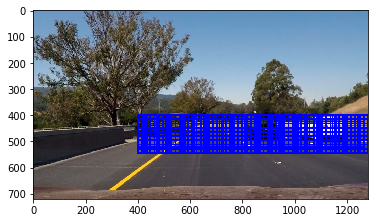

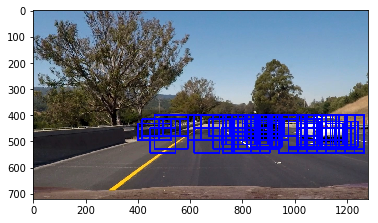

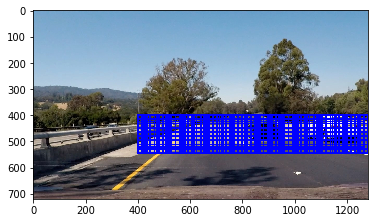

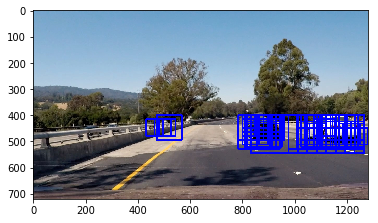

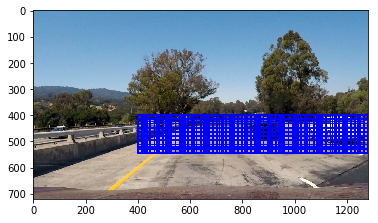

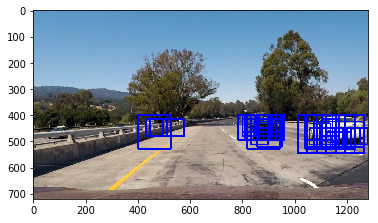

In [10]:
%matplotlib inline
# Check the prediction time for a single sample
t=time.time()

test_images = glob.glob('./test_images/test*.jpg')

for image_name in test_images:

    image = mpimg.imread(image_name)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255
    y_start_stop = [400, 550] # Min and max in y to search in slide_window()
    windows = slide_window(image, x_start_stop=[400, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    
    windows += slide_window(image, x_start_stop=[400, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    
    windows += slide_window(image, x_start_stop=[400, None], y_start_stop=y_start_stop, 
                        xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    
    windows += slide_window(image, x_start_stop=[400, None], y_start_stop=y_start_stop, 
                        xy_window=(144, 144), xy_overlap=(0.75, 0.75))
    
    
    window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)                    

    plt.figure()
    plt.imshow(window_img)
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.figure()
    plt.imshow(window_img)

##### Observations from search windows function
Inputs that I observed impacts the performance: windows size (xy_size) and windows verlap (xy_overlap)
At the higher size (128) the large cars are detected properly and small car siuzes are not recognized. At smaller window size, small car sizes detected properly and larger car sizes are not covered properly.

xy_verlap seems have an impact on the number of times the box is placed on the car. Especially it helps with smaller window size for larger cars where the number if box instances for a given pixel will have higher count

Based on trial and error with Min size of 64 and max size of 144 seems working fine.



#### Create a function that combined both search window and find_cars logic to return detected bounding boxes

In [11]:
##### Testing code for Find Cars
ystart = 400
ystop = 650
xstart = 400
xstop = None
scale = 1.5
def combine_search_and_find_car_boxes(mp_image):
    bounding_boxes = []
    #out_img, bounding_boxes = find_cars(mp_image, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel)
    #print(len(bounding_boxes))
    #plt.imshow(out_img)
#'''
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = mp_image.astype(np.float32)/255
    y_start_stop = [400, 550] # Min and max in y to search in slide_window()
    x_start_stop = [400, None]
    xy_overlap_param = (0.75, 0.75)

    windows = slide_window(image, x_start_stop=[400, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=xy_overlap_param)
    
    windows += slide_window(image, x_start_stop=[400, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=xy_overlap_param)
    
    windows += slide_window(image, x_start_stop=[400, None], y_start_stop=y_start_stop, 
                        xy_window=(128, 128), xy_overlap=xy_overlap_param)
    
    windows += slide_window(image, x_start_stop=[400, None], y_start_stop=y_start_stop, 
                        xy_window=(144, 144), xy_overlap=xy_overlap_param)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
#'''
    #print(len(hot_windows))
    
    return bounding_boxes  + hot_windows

##### Find Cars Test

/home/ramesh/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


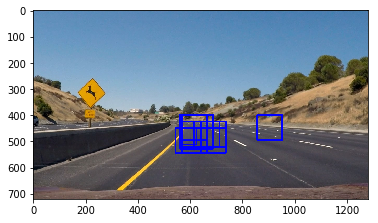

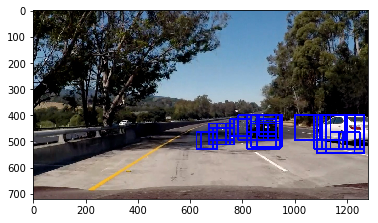

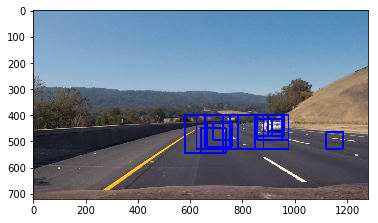

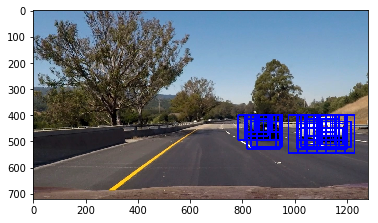

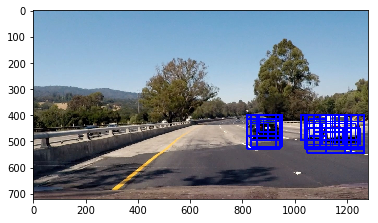

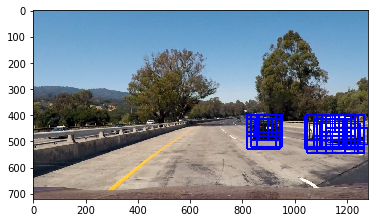

In [12]:


#orient = 9  # HOG orientations
#pix_per_cell = 8 # HOG pixels per cell
#cell_per_block = 2 # HOG cells per block
#hog_channel = 0 # Can be 0, 1, 2, or "ALL"
#spatial_size = (32, 32) # Spatial binning dimensions
#hist_bins = 32    # Number of histogram bins
test_images = glob.glob('./test_images/test*.jpg')

for image_name in test_images:

    img = mpimg.imread(image_name)
    #img = img.astype(np.float32)/255
    res_boxes = combine_search_and_find_car_boxes(img)

    window_img = draw_boxes(img, res_boxes, color=(0, 0, 255), thick=6)                    
    plt.figure()
    plt.imshow(window_img)

#### Add functions to find the heat map and from there eliminate the false positives


In [13]:
import cv2
from scipy.ndimage.measurements import label

# Function: add_heat()
# Takes heatmap and bounding boxes for the identgified cars
# Set all pixels within the bouding boxed within heat map to 1 and add 1 more if there is an overlap with the bounding box area
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Function: apply_threshold
# Takes heatmap and a threshold using which to set the pixel values to 0, if the pixel value count is less than the threshold.
# This will help in identifying the false positives that occur rarely

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
# Function: filter_box_by_width
# Taken bounding box as input and return True if this is considered as valid box
# i.e. height is more than 1.2/1.5x that the width
def filter_box_by_width(box, h_factor=1.2):

    b_height = box[1][1] - box[0][1]
    b_width = box[1][0] - box[0][0]
    
    if ((b_height > h_factor*b_width) or (b_height < b_width/4)):
        return False
    else:
        return True

# Function: draw_labeled_boxes
# Takes image and the labels data structure for the cars identified for that image
def return_labeled_bboxes(labels):
    b_boxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        if (filter_box_by_width(bbox)):
            print(bbox[0][1],bbox[1][1], bbox[0][0],bbox[1][0])
            print ('Width, Height', bbox[1][0] - bbox[0][0], bbox[1][1] - bbox[0][1])
            # Filter the bounding box that is having less width than the height
            b_boxes.append(bbox)
            
    # Return the image
    return b_boxes

def draw_labeled_bboxes(img, bboxes):
    for bbox in bboxes:
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    return img
    

In [30]:
# Class to store the last 6 frames of heatmap data
class Heatmap_Log():
    def __init__(self, max_list_count, jump_in_size):
        # number of fitted line coefficents to store
        self.max_list_count = max_list_count
        self.jump_in_size = jump_in_size
        # values of the last n heatmaps
        self.recent_fitted = [] 
        
        # Store bounding boxed from the last max_list_count frames
        self.recent_bboxes = []
  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
    
    def get_fit_coeff(self):
        return self.best_fit
    
    def get_list_count(self):
        return len(self.recent_fitted)
    
    def set_fit_coeff(self, coeff):
        self.recent_fitted.append(coeff)
        
        if (len(self.recent_fitted) > self.max_list_count):
            _ = self.recent_fitted.pop(0) 
        
        self.best_fit = np.sum(self.recent_fitted, axis=0)
        return self.get_fit_coeff()
    
    def set_recent_bbox(self, bboxs):
        self.recent_bboxes.append(bboxs)
        
        if (len(self.recent_bboxes) > self.max_list_count):
            _ = self.recent_bboxes.pop(0) 
        
        return self.recent_bboxes
    
    def get_recent_bbox_list(self):
        return self.recent_bboxes
    
    def get_pop_bbox_list(self):
        if (len(self.recent_bboxes) > 0):
            _ = self.recent_bboxes.pop(0)
    
    def init_coeff(self):
        self.recent_fitted = [] 
        
    def get_max_count(self):
        return self.max_list_count
    
    def get_jump_in_size(self):
        return self.jump_in_size
    

# Init Heatmap log to store last 6 heatmaps
h_log = Heatmap_Log(6, 1.5)
THRESHOLD = 4
MATCHES_THRESHOLD = 8
SIZE_THRESHOLD = 20
DISTANCE_THRESHOLD = 25

#### Apply heatmap and threshold filters here 

1
424 519 568 663
Width, Height 95 95
1
400 495 832 927
Width, Height 95 95
400 527 1120 1231
Width, Height 111 127
1
416 479 896 951
Width, Height 55 63
1
400 495 816 927
Width, Height 111 95
400 527 1024 1199
Width, Height 175 127
1
400 527 1048 1239
Width, Height 191 127
416 495 832 927
Width, Height 95 79
1
400 495 832 943
Width, Height 111 95
400 527 1056 1263
Width, Height 207 127


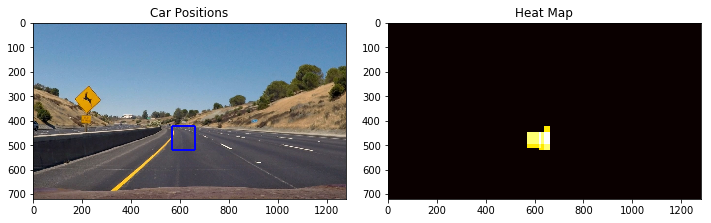

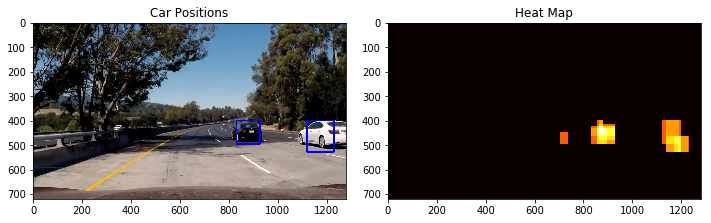

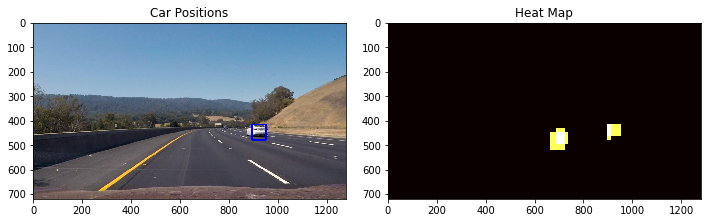

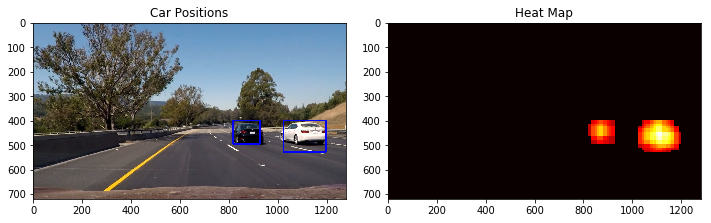

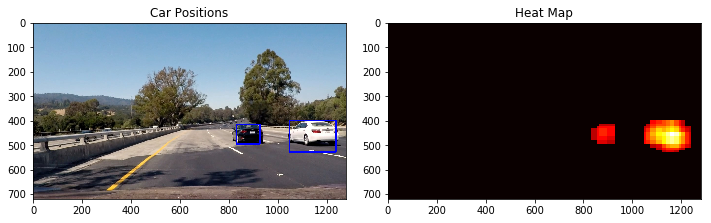

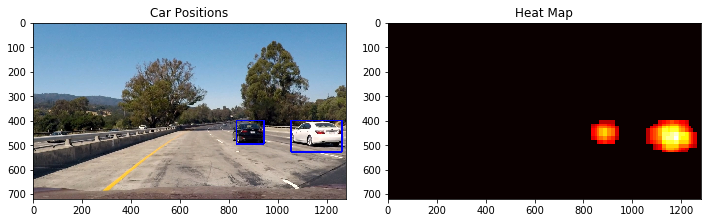

In [33]:

def return_heat_for_boxes(image, boxes):
    # Init heatmap same size as the image
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, boxes)
    
    return heat

def appy_heatmap_threshold(image, boxes, isVideo):
    heat = return_heat_for_boxes(image, boxes)
    
    if (isVideo == True):
        #Store this heat to the log
        heat = h_log.set_fit_coeff(heat)

        # Apply threshold to help remove false positives
        #past_heat_counts = h_log.get_list_count()
        past_heat_counts = h_log.get_max_count()
    else:
        past_heat_counts = 1
        h_log.init_coeff()
        
    print(past_heat_counts)
    heat = apply_threshold(heat, THRESHOLD*past_heat_counts)

    # Visualize the heatmap when displaying    
    heatmap_vis = np.clip(heat, 0, 255)

    return heatmap_vis, heat

def find_lables_from_heatmap(heatmap):
    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    return labels

# Function to find the center of the bounding box
def return_center_of_bbox(box):
    tl_x, tl_y = box[0]
    br_x, br_y = box[1]
    c_x = (br_x+tl_x)/2.
    c_y = (br_y+tl_y)/2.
    
    return (c_x, c_y)

# Function to get the width and height of the bouding box
def return_width_height_of_box(box):
    tl_x, tl_y = box[0]
    br_x, br_y = box[1]
    
    b_width = (br_x-tl_x)
    b_height = (br_y-tl_y)
    
    return (b_width, b_height)

# Function to get distance between two points
def return_distance(point1, point2):
    dist = np.sqrt((point2[0]-point1[0])**2 + (point2[1]-point1[1])**2)
    
    return dist

# return the gradient between two points
def return_gradient(point1, point2):
    grad = (point2[1]-point1[1])/(point2[0]-point1[0])
    
    return grad

# Function to check if the cur box is similar to prev box
def is_boxes_similar(cur_box, prev_box):
    size_threshold = SIZE_THRESHOLD
    c_w, c_h = return_width_height_of_box(cur_box)
    p_w, p_h = return_width_height_of_box(prev_box)
    
    if ((np.absolute(c_w-p_w) < size_threshold) and (np.absolute(c_h-p_h) < size_threshold)):
        return True
    else:
        return False
    
# Function to provide a directional check between similar bounding box in prev frame vs current
def find_gradient_and_distance_between_boxes(cur_box, prev_box):
    cur_box_center = return_center_of_bbox(cur_box)
    prev_box_center = return_center_of_bbox(prev_box)
    
    b_distance = return_distance(cur_box_center, prev_box_center)
    b_grad = return_gradient(cur_box_center, prev_box_center)
    
    return b_distance, b_grad
    

# function to validate the current bounding box based on prev frame bounding boxes
def check_against_prev_boxes(current_boxes, isVideo = False):
    
    if (isVideo == False):
        return current_boxes
    # Check if current_boxes has any boxes inside, if not then remove the last stored boxes list from the storage
    if (len(current_boxes) == 0):
        h_log.get_pop_bbox_list()
        return current_boxes
    boxes_to_be_shown = []
    # Get the boxes from prev 
    prev_box_list = h_log.get_recent_bbox_list()
    prev_box_list_count = len(prev_box_list)
    # For each box in bounding boxes identied in current frame
    for cur_box in current_boxes:
        found_matches = 0
        prev_node_weight = 0
        # Find out if this box matches with one of the boxes in the prev frames 
        for n_p_c in range(0, prev_box_list_count):
            # Make sure that the recent history of prev values take higher weightage
            prev_node_weight += 0.5
            for prev_box in prev_box_list[n_p_c]:
                b_dis, b_grad = find_gradient_and_distance_between_boxes(cur_box, prev_box)
                is_similar = is_boxes_similar(cur_box, prev_box)
                if ((is_similar == True) and(b_dis <= DISTANCE_THRESHOLD)):
                    found_matches += prev_node_weight
            print('Matches', found_matches)
        
        # IF the current box is atleast 5 times matches in the prev 6 frames, consider it to be shown
        if (found_matches > MATCHES_THRESHOLD):
            boxes_to_be_shown.append(cur_box)
    h_log.set_recent_bbox(current_boxes)
        
    
    return boxes_to_be_shown

def detect_cars_in_image(mp_image, isVideo = False):
    # Combine results from search_windows & find Windows
    combined_boxes = combine_search_and_find_car_boxes(mp_image)
    # Apply threshold here
    heatmap_vis, heat = appy_heatmap_threshold(mp_image, combined_boxes, isVideo)
    labels = find_lables_from_heatmap(heat)
    # Find the boxes given the labels derived from heatmap
    bboxes = return_labeled_bboxes(labels)
    
    # Check against the already stored last 6 frames data to see if the current boxes are valid
    bboxes = check_against_prev_boxes(bboxes, isVideo)
    
    # Draw the bounding box for the filtered boxes
    draw_img = draw_labeled_bboxes(np.copy(mp_image), bboxes)
    #draw_img, bboxes = find_lables_from_heatmap(heat, mp_image)
    return draw_img, heatmap_vis

# Test the threshold function 
test_images = glob.glob('./test_images/test*.jpg')

for image_name in test_images:

    img = mpimg.imread(image_name)
    draw_img, heatmap = detect_cars_in_image(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    f.tight_layout()
    #plt.subplot(1,2, 1)
    ax1.imshow(draw_img)
    ax1.set_title('Car Positions')
    #plt.subplot(1, 2, 2)
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('Heat Map')
    #fig.tight_layout()

#### Functions to take care of the prev frame detection vs current frame and see whether this should be considered or not

### Testing the lane detection code from the prev project
Converted the code to .py file and imported that as advanced_lane_detection module
https://github.com/rnaidu02/CarND-Advanced-Lane-Lines/blob/master/Advanced-Lane-Detection.ipynb

#### Code that uses process_image function to find lanes from each frame of the video

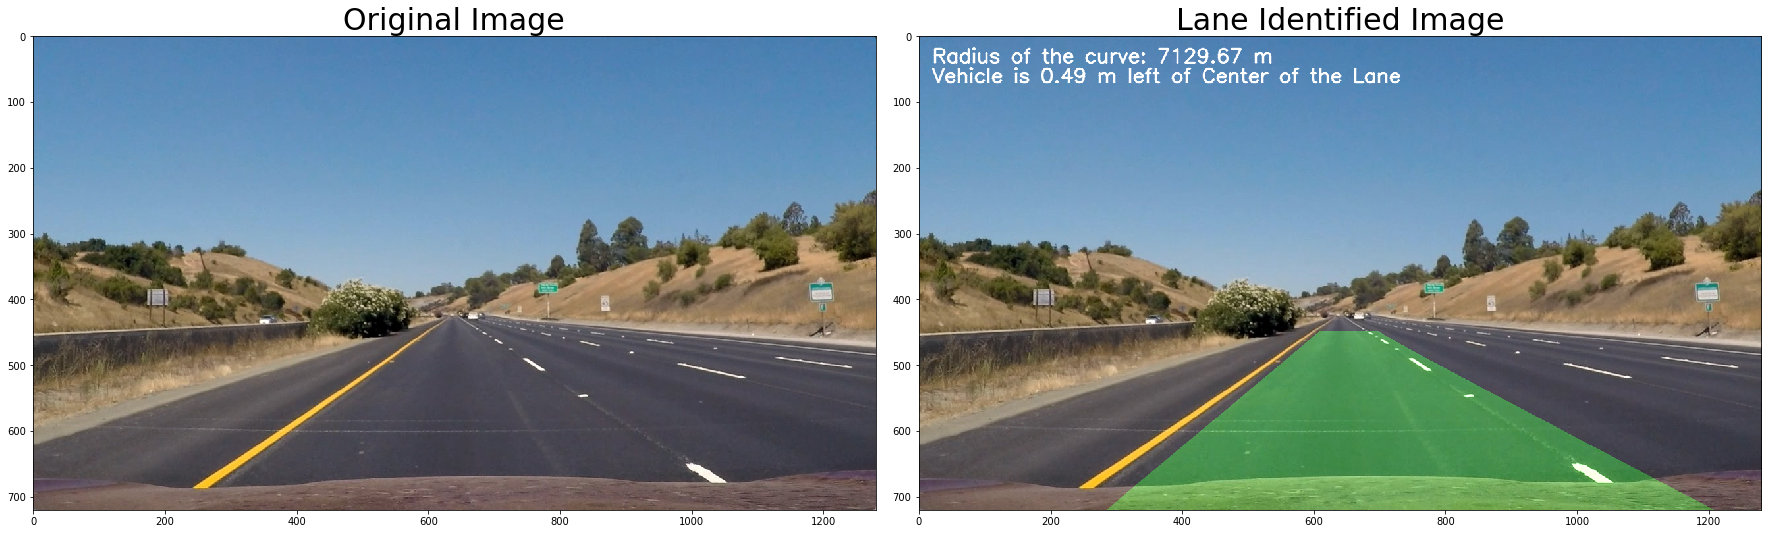

In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import advanced_lane_detection
import glob

%matplotlib qt
%matplotlib inline

img = mpimg.imread('test_images/straight_lines1.jpg')
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
already_detected = False
result = advanced_lane_detection.process_image(img)
ax2.imshow(result)
ax2.set_title('Lane Identified Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Add function that merges both lane detection and vehicle detection together


In [35]:
#Add function that merges both lane detection and vehicle detection together

def merge_laneandvehicle_detect(image):
    lane_img = image
    #lane_img = advanced_lane_detection.process_image(lane_img)

    lane_img, _ = detect_cars_in_image(lane_img, True)

    return lane_img

# def process_video(input_video, output_video)

# Import everything needed to edit/save/watch video clips

from moviepy.editor import VideoFileClip

from IPython.display import HTML

def process_video(input_video, output_video):


    clip2 = VideoFileClip(input_video) #.subclip(0, 15)

    out_clip = clip2.fl_image(merge_laneandvehicle_detect)

    out_clip.write_videofile(output_video, audio=False)


process_video('project_video.mp4', 'output.mp4')



6
[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4



  0%|          | 1/1261 [00:00<16:25,  1.28it/s]

6



  0%|          | 2/1261 [00:01<16:26,  1.28it/s]

6



  0%|          | 3/1261 [00:02<16:25,  1.28it/s]

6



  0%|          | 4/1261 [00:03<16:27,  1.27it/s]

6
448 519 592 663
Width, Height 71 71



  0%|          | 5/1261 [00:03<16:29,  1.27it/s]

6
448 519 568 663
Width, Height 95 71
Matches 0



  0%|          | 6/1261 [00:04<16:28,  1.27it/s]

6
448 519 568 663
Width, Height 95 71
Matches 0
Matches 1.0



  1%|          | 7/1261 [00:05<16:27,  1.27it/s]

6
448 527 568 687
Width, Height 119 79
Matches 0
Matches 0
Matches 0



  1%|          | 8/1261 [00:06<16:26,  1.27it/s]

6
448 527 560 687
Width, Height 127 79
Matches 0
Matches 0
Matches 0
Matches 2.0



  1%|          | 9/1261 [00:07<16:25,  1.27it/s]

6
448 527 560 663
Width, Height 103 79
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 4.5



  1%|          | 10/1261 [00:07<16:24,  1.27it/s]

6
448 527 560 663
Width, Height 103 79
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 4.5
Matches 7.5



  1%|          | 11/1261 [00:08<16:23,  1.27it/s]

6
448 527 568 663
Width, Height 95 79
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.0
Matches 7.0



  1%|          | 12/1261 [00:09<16:35,  1.25it/s]

6
448 527 560 663
Width, Height 103 79
Matches 0.5
Matches 1.5
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



  1%|          | 13/1261 [00:10<16:29,  1.26it/s]

6
448 527 560 663
Width, Height 103 79
Matches 0.5
Matches 0.5
Matches 2.0
Matches 4.0
Matches 6.5
Matches 9.5



  1%|          | 14/1261 [00:11<16:40,  1.25it/s]

6
448 519 568 639
Width, Height 71 71
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



  1%|          | 15/1261 [00:11<16:34,  1.25it/s]

6



  1%|▏         | 16/1261 [00:12<16:28,  1.26it/s]

6



  1%|▏         | 17/1261 [00:13<16:31,  1.25it/s]

6



  1%|▏         | 18/1261 [00:14<16:26,  1.26it/s]

6



  2%|▏         | 19/1261 [00:15<16:22,  1.26it/s]

6



  2%|▏         | 20/1261 [00:15<16:18,  1.27it/s]

6



  2%|▏         | 21/1261 [00:16<16:16,  1.27it/s]

6



  2%|▏         | 22/1261 [00:17<16:14,  1.27it/s]

6



  2%|▏         | 23/1261 [00:18<16:11,  1.27it/s]

6



  2%|▏         | 24/1261 [00:18<16:11,  1.27it/s]

6



  2%|▏         | 25/1261 [00:19<16:09,  1.27it/s]

6



  2%|▏         | 26/1261 [00:20<16:08,  1.27it/s]

6



  2%|▏         | 27/1261 [00:21<16:06,  1.28it/s]

6



  2%|▏         | 28/1261 [00:22<16:05,  1.28it/s]

6



  2%|▏         | 29/1261 [00:22<16:04,  1.28it/s]

6



  2%|▏         | 30/1261 [00:23<16:04,  1.28it/s]

6



  2%|▏         | 31/1261 [00:24<16:18,  1.26it/s]

6



  3%|▎         | 32/1261 [00:25<16:13,  1.26it/s]

6



  3%|▎         | 33/1261 [00:26<16:21,  1.25it/s]

6



  3%|▎         | 34/1261 [00:26<16:28,  1.24it/s]

6



  3%|▎         | 35/1261 [00:27<16:20,  1.25it/s]

6



  3%|▎         | 36/1261 [00:28<16:18,  1.25it/s]

6



  3%|▎         | 37/1261 [00:29<16:10,  1.26it/s]

6



  3%|▎         | 38/1261 [00:30<16:06,  1.26it/s]

6



  3%|▎         | 39/1261 [00:30<16:03,  1.27it/s]

6



  3%|▎         | 40/1261 [00:31<17:05,  1.19it/s]

6



  3%|▎         | 41/1261 [00:32<16:50,  1.21it/s]

6



  3%|▎         | 42/1261 [00:33<16:50,  1.21it/s]

6



  3%|▎         | 43/1261 [00:34<16:47,  1.21it/s]

6



  3%|▎         | 44/1261 [00:35<16:35,  1.22it/s]

6



  4%|▎         | 45/1261 [00:35<16:55,  1.20it/s]

6



  4%|▎         | 46/1261 [00:36<16:46,  1.21it/s]

6



  4%|▎         | 47/1261 [00:37<16:54,  1.20it/s]

6



  4%|▍         | 48/1261 [00:38<16:38,  1.22it/s]

6
448 495 592 639
Width, Height 47 47



  4%|▍         | 49/1261 [00:39<16:26,  1.23it/s]

6
448 495 568 663
Width, Height 95 47
Matches 0



  4%|▍         | 50/1261 [00:39<16:16,  1.24it/s]

6
448 511 568 663
Width, Height 95 63
480 495 1024 1039
Width, Height 15 15
Matches 0
Matches 1.0
Matches 0
Matches 0



  4%|▍         | 51/1261 [00:40<16:07,  1.25it/s]

6
448 519 568 639
Width, Height 71 71
Matches 0
Matches 0
Matches 0



  4%|▍         | 52/1261 [00:41<16:00,  1.26it/s]

6
448 495 568 639
Width, Height 71 47
Matches 0
Matches 0
Matches 0
Matches 0



  4%|▍         | 53/1261 [00:42<15:55,  1.26it/s]

6
448 495 568 639
Width, Height 71 47
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5



  4%|▍         | 54/1261 [00:43<15:51,  1.27it/s]

6
448 495 568 623
Width, Height 55 47
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 3.0
Matches 6.0



  4%|▍         | 55/1261 [00:43<15:49,  1.27it/s]

6



  4%|▍         | 56/1261 [00:44<15:46,  1.27it/s]

6



  5%|▍         | 57/1261 [00:45<15:44,  1.27it/s]

6



  5%|▍         | 58/1261 [00:46<15:42,  1.28it/s]

6



  5%|▍         | 59/1261 [00:46<15:41,  1.28it/s]

6



  5%|▍         | 60/1261 [00:47<15:40,  1.28it/s]

6



  5%|▍         | 61/1261 [00:48<15:40,  1.28it/s]

6



  5%|▍         | 62/1261 [00:49<16:08,  1.24it/s]

6



  5%|▍         | 63/1261 [00:50<16:38,  1.20it/s]

6
464 495 1168 1215
Width, Height 47 31



  5%|▌         | 64/1261 [00:51<16:21,  1.22it/s]

6
464 495 1184 1231
Width, Height 47 31
Matches 0.5



  5%|▌         | 65/1261 [00:51<16:06,  1.24it/s]

6



  5%|▌         | 66/1261 [00:52<15:57,  1.25it/s]

6



  5%|▌         | 67/1261 [00:53<15:50,  1.26it/s]

6



  5%|▌         | 68/1261 [00:54<15:44,  1.26it/s]

6



  5%|▌         | 69/1261 [00:55<15:41,  1.27it/s]

6



  6%|▌         | 70/1261 [00:55<15:40,  1.27it/s]

6



  6%|▌         | 71/1261 [00:56<15:39,  1.27it/s]

6



  6%|▌         | 72/1261 [00:57<16:07,  1.23it/s]

6



  6%|▌         | 73/1261 [00:58<15:56,  1.24it/s]

6



  6%|▌         | 74/1261 [00:59<15:49,  1.25it/s]

6



  6%|▌         | 75/1261 [00:59<15:44,  1.26it/s]

6



  6%|▌         | 76/1261 [01:00<15:41,  1.26it/s]

6



  6%|▌         | 77/1261 [01:01<15:37,  1.26it/s]

6



  6%|▌         | 78/1261 [01:02<15:40,  1.26it/s]

6



  6%|▋         | 79/1261 [01:03<15:36,  1.26it/s]

6



  6%|▋         | 80/1261 [01:03<15:44,  1.25it/s]

6



  6%|▋         | 81/1261 [01:04<15:38,  1.26it/s]

6



  7%|▋         | 82/1261 [01:05<15:34,  1.26it/s]

6



  7%|▋         | 83/1261 [01:06<15:31,  1.26it/s]

6



  7%|▋         | 84/1261 [01:06<15:28,  1.27it/s]

6



  7%|▋         | 85/1261 [01:07<15:26,  1.27it/s]

6



  7%|▋         | 86/1261 [01:08<15:24,  1.27it/s]

6



  7%|▋         | 87/1261 [01:09<15:22,  1.27it/s]

6



  7%|▋         | 88/1261 [01:10<15:20,  1.27it/s]

6



  7%|▋         | 89/1261 [01:10<15:19,  1.27it/s]

6



  7%|▋         | 90/1261 [01:11<15:18,  1.28it/s]

6



  7%|▋         | 91/1261 [01:12<15:18,  1.27it/s]

6



  7%|▋         | 92/1261 [01:13<15:17,  1.27it/s]

6



  7%|▋         | 93/1261 [01:14<15:16,  1.28it/s]

6



  7%|▋         | 94/1261 [01:14<15:14,  1.28it/s]

6



  8%|▊         | 95/1261 [01:15<15:13,  1.28it/s]

6



  8%|▊         | 96/1261 [01:16<15:12,  1.28it/s]

6



  8%|▊         | 97/1261 [01:17<15:10,  1.28it/s]

6



  8%|▊         | 98/1261 [01:17<15:10,  1.28it/s]

6



  8%|▊         | 99/1261 [01:18<15:09,  1.28it/s]

6



  8%|▊         | 100/1261 [01:19<15:08,  1.28it/s]

6



  8%|▊         | 101/1261 [01:20<15:07,  1.28it/s]

6



  8%|▊         | 102/1261 [01:21<15:12,  1.27it/s]

6



  8%|▊         | 103/1261 [01:21<15:13,  1.27it/s]

6



  8%|▊         | 104/1261 [01:22<15:11,  1.27it/s]

6



  8%|▊         | 105/1261 [01:23<15:09,  1.27it/s]

6



  8%|▊         | 106/1261 [01:24<15:09,  1.27it/s]

6



  8%|▊         | 107/1261 [01:25<15:07,  1.27it/s]

6



  9%|▊         | 108/1261 [01:25<15:11,  1.26it/s]

6



  9%|▊         | 109/1261 [01:26<15:08,  1.27it/s]

6



  9%|▊         | 110/1261 [01:27<15:07,  1.27it/s]

6



  9%|▉         | 111/1261 [01:28<15:06,  1.27it/s]

6



  9%|▉         | 112/1261 [01:28<15:06,  1.27it/s]

6



  9%|▉         | 113/1261 [01:29<15:05,  1.27it/s]

6



  9%|▉         | 114/1261 [01:30<15:04,  1.27it/s]

6



  9%|▉         | 115/1261 [01:31<15:02,  1.27it/s]

6



  9%|▉         | 116/1261 [01:32<15:01,  1.27it/s]

6



  9%|▉         | 117/1261 [01:32<15:18,  1.24it/s]

6



  9%|▉         | 118/1261 [01:33<15:12,  1.25it/s]

6



  9%|▉         | 119/1261 [01:34<15:07,  1.26it/s]

6



 10%|▉         | 120/1261 [01:35<15:04,  1.26it/s]

6



 10%|▉         | 121/1261 [01:36<15:03,  1.26it/s]

6



 10%|▉         | 122/1261 [01:36<14:59,  1.27it/s]

6



 10%|▉         | 123/1261 [01:37<14:57,  1.27it/s]

6



 10%|▉         | 124/1261 [01:38<14:56,  1.27it/s]

6



 10%|▉         | 125/1261 [01:39<14:55,  1.27it/s]

6
480 519 1200 1239
Width, Height 39 39



 10%|▉         | 126/1261 [01:40<14:53,  1.27it/s]

6
464 519 1184 1239
Width, Height 55 55
Matches 0.5



 10%|█         | 127/1261 [01:40<14:52,  1.27it/s]

6
448 511 1184 1239
Width, Height 55 63
Matches 0
Matches 1.0



 10%|█         | 128/1261 [01:41<14:50,  1.27it/s]

6
464 511 1184 1239
Width, Height 55 47
Matches 0.5
Matches 1.5
Matches 3.0



 10%|█         | 129/1261 [01:42<14:50,  1.27it/s]

6
448 511 1184 1239
Width, Height 55 63
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5



 10%|█         | 130/1261 [01:43<14:48,  1.27it/s]

6



 10%|█         | 131/1261 [01:44<15:42,  1.20it/s]

6
464 511 1184 1231
Width, Height 47 47
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0



 10%|█         | 132/1261 [01:44<15:26,  1.22it/s]

6
448 511 1168 1227
Width, Height 59 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5



 11%|█         | 133/1261 [01:45<15:14,  1.23it/s]

6



 11%|█         | 134/1261 [01:46<15:04,  1.25it/s]

6



 11%|█         | 135/1261 [01:47<14:57,  1.26it/s]

6



 11%|█         | 136/1261 [01:48<14:52,  1.26it/s]

6



 11%|█         | 137/1261 [01:48<14:49,  1.26it/s]

6



 11%|█         | 138/1261 [01:49<14:46,  1.27it/s]

6
448 511 568 639
Width, Height 71 63
Matches 0



 11%|█         | 139/1261 [01:50<14:45,  1.27it/s]

6
448 511 568 639
Width, Height 71 63
Matches 0
Matches 1.0



 11%|█         | 140/1261 [01:51<14:45,  1.27it/s]

6
448 511 568 639
Width, Height 71 63
Matches 0
Matches 1.0
Matches 2.5



 11%|█         | 141/1261 [01:51<14:43,  1.27it/s]

6
448 495 568 639
Width, Height 71 47
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5



 11%|█▏        | 142/1261 [01:52<14:43,  1.27it/s]

6
480 495 1168 1191
Width, Height 23 15
480 495 1200 1231
Width, Height 31 15
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 11%|█▏        | 143/1261 [01:53<14:41,  1.27it/s]

6
480 495 1216 1231
Width, Height 15 15
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 11%|█▏        | 144/1261 [01:54<14:41,  1.27it/s]

6
480 495 1200 1231
Width, Height 31 15
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 11%|█▏        | 145/1261 [01:55<14:41,  1.27it/s]

6
480 511 1200 1231
Width, Height 31 31
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 12%|█▏        | 146/1261 [01:55<14:41,  1.26it/s]

6



 12%|█▏        | 147/1261 [01:56<14:41,  1.26it/s]

6
480 495 1200 1215
Width, Height 15 15
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0



 12%|█▏        | 148/1261 [01:57<14:40,  1.26it/s]

6
448 519 592 663
Width, Height 71 71
480 495 1200 1215
Width, Height 15 15
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 12%|█▏        | 149/1261 [01:58<14:40,  1.26it/s]

6
448 519 592 663
Width, Height 71 71
448 511 1168 1231
Width, Height 63 63
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 12%|█▏        | 150/1261 [01:59<14:38,  1.26it/s]

6
448 519 1168 1231
Width, Height 63 71
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 12%|█▏        | 151/1261 [01:59<14:37,  1.27it/s]

6



 12%|█▏        | 152/1261 [02:00<14:37,  1.26it/s]

6
448 519 592 663
Width, Height 71 71
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 3.5



 12%|█▏        | 153/1261 [02:01<14:35,  1.27it/s]

6



 12%|█▏        | 154/1261 [02:02<14:34,  1.27it/s]

6
448 495 592 639
Width, Height 47 47
464 519 1136 1199
Width, Height 63 55
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 12%|█▏        | 155/1261 [02:03<14:33,  1.27it/s]

6
464 519 1136 1191
Width, Height 55 55
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 12%|█▏        | 156/1261 [02:03<14:34,  1.26it/s]

6
464 519 1136 1191
Width, Height 55 55
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 12%|█▏        | 157/1261 [02:04<14:31,  1.27it/s]

6
464 527 1136 1215
Width, Height 79 63
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 2.0
Matches 2.0



 13%|█▎        | 158/1261 [02:05<14:30,  1.27it/s]

6
464 527 1144 1215
Width, Height 71 63
Matches 0.5
Matches 0.5
Matches 2.0
Matches 4.0
Matches 6.5
Matches 9.5



 13%|█▎        | 159/1261 [02:06<14:29,  1.27it/s]

6
448 527 1136 1239
Width, Height 103 79
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 13%|█▎        | 160/1261 [02:06<14:27,  1.27it/s]

6
448 527 1136 1239
Width, Height 103 79
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 13%|█▎        | 161/1261 [02:07<14:26,  1.27it/s]

6
448 527 1136 1239
Width, Height 103 79
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 13%|█▎        | 162/1261 [02:08<14:25,  1.27it/s]

6
424 527 1120 1247
Width, Height 127 103
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 13%|█▎        | 163/1261 [02:09<14:24,  1.27it/s]

6
424 527 1104 1263
Width, Height 159 103
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 13%|█▎        | 164/1261 [02:10<14:23,  1.27it/s]

6
424 527 1104 1263
Width, Height 159 103
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 13%|█▎        | 165/1261 [02:10<14:22,  1.27it/s]

6
416 527 1104 1263
Width, Height 159 111
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 13%|█▎        | 166/1261 [02:11<14:22,  1.27it/s]

6
400 527 1104 1263
Width, Height 159 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 13%|█▎        | 167/1261 [02:12<14:21,  1.27it/s]

6
400 527 1120 1263
Width, Height 143 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 13%|█▎        | 168/1261 [02:13<14:21,  1.27it/s]

6
400 527 1120 1263
Width, Height 143 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 13%|█▎        | 169/1261 [02:14<14:21,  1.27it/s]

6
400 527 1120 1263
Width, Height 143 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 13%|█▎        | 170/1261 [02:14<14:19,  1.27it/s]

6
400 527 1104 1263
Width, Height 159 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 14%|█▎        | 171/1261 [02:15<14:19,  1.27it/s]

6
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 14%|█▎        | 172/1261 [02:16<14:18,  1.27it/s]

6
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 14%|█▎        | 173/1261 [02:17<14:17,  1.27it/s]

6
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 14%|█▍        | 174/1261 [02:18<14:18,  1.27it/s]

6
400 527 1104 1247
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 14%|█▍        | 175/1261 [02:18<14:17,  1.27it/s]

6
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 14%|█▍        | 176/1261 [02:19<14:16,  1.27it/s]

6
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 14%|█▍        | 177/1261 [02:20<15:27,  1.17it/s]

6
400 527 1096 1263
Width, Height 167 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 14%|█▍        | 178/1261 [02:21<15:11,  1.19it/s]

6
400 527 1096 1263
Width, Height 167 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 14%|█▍        | 179/1261 [02:22<15:32,  1.16it/s]

6
400 527 1084 1263
Width, Height 179 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 14%|█▍        | 180/1261 [02:23<15:43,  1.15it/s]

6
400 527 1084 1263
Width, Height 179 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 14%|█▍        | 181/1261 [02:24<15:27,  1.16it/s]

6
400 527 1096 1263
Width, Height 167 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 14%|█▍        | 182/1261 [02:24<15:10,  1.19it/s]

6
400 527 1096 1263
Width, Height 167 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 15%|█▍        | 183/1261 [02:25<15:08,  1.19it/s]

6
400 527 1096 1263
Width, Height 167 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 15%|█▍        | 184/1261 [02:26<14:52,  1.21it/s]

6
400 527 1084 1263
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 15%|█▍        | 185/1261 [02:27<14:41,  1.22it/s]

6
400 527 1088 1247
Width, Height 159 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 6.0



 15%|█▍        | 186/1261 [02:28<14:32,  1.23it/s]

6
400 527 1088 1247
Width, Height 159 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 4.5
Matches 7.5



 15%|█▍        | 187/1261 [02:28<14:25,  1.24it/s]

6
400 527 1084 1247
Width, Height 163 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 15%|█▍        | 188/1261 [02:29<14:20,  1.25it/s]

6
400 527 1084 1239
Width, Height 155 127
480 511 560 607
Width, Height 47 31
Matches 0.5
Matches 1.5
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 15%|█▍        | 189/1261 [02:30<14:17,  1.25it/s]

6
400 527 1084 1239
Width, Height 155 127
464 511 560 607
Width, Height 47 47
Matches 0.5
Matches 0.5
Matches 2.0
Matches 4.0
Matches 6.5
Matches 9.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 15%|█▌        | 190/1261 [02:31<14:22,  1.24it/s]

6
400 527 1084 1231
Width, Height 147 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 15%|█▌        | 191/1261 [02:32<14:18,  1.25it/s]

6
400 527 1084 1231
Width, Height 147 127
464 519 568 623
Width, Height 55 55
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 2.5



 15%|█▌        | 192/1261 [02:32<14:16,  1.25it/s]

6
400 527 1072 1231
Width, Height 159 127
464 519 568 623
Width, Height 55 55
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 2.0
Matches 5.0



 15%|█▌        | 193/1261 [02:33<14:14,  1.25it/s]

6
400 527 1072 1231
Width, Height 159 127
448 527 568 639
Width, Height 71 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 15%|█▌        | 194/1261 [02:34<14:16,  1.25it/s]

6
400 527 1072 1231
Width, Height 159 127
448 527 568 639
Width, Height 71 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 15%|█▌        | 195/1261 [02:35<14:14,  1.25it/s]

6
400 527 1072 1231
Width, Height 159 127
448 527 560 639
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 16%|█▌        | 196/1261 [02:36<14:15,  1.25it/s]

6
400 527 1072 1247
Width, Height 175 127
448 527 560 639
Width, Height 79 79
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 16%|█▌        | 197/1261 [02:36<14:14,  1.25it/s]

6
400 527 1072 1247
Width, Height 175 127
448 527 560 639
Width, Height 79 79
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 16%|█▌        | 198/1261 [02:37<14:09,  1.25it/s]

6
400 527 1072 1247
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 16%|█▌        | 199/1261 [02:38<14:07,  1.25it/s]

6
400 527 1084 1247
Width, Height 163 127
448 511 560 615
Width, Height 55 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5



 16%|█▌        | 200/1261 [02:39<14:38,  1.21it/s]

6
400 527 1084 1247
Width, Height 163 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 16%|█▌        | 201/1261 [02:40<14:31,  1.22it/s]

6
400 527 1072 1263
Width, Height 191 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 4.5
Matches 4.5



 16%|█▌        | 202/1261 [02:40<14:21,  1.23it/s]

6
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 3.0
Matches 6.0



 16%|█▌        | 203/1261 [02:41<14:13,  1.24it/s]

6
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.0
Matches 7.0



 16%|█▌        | 204/1261 [02:42<14:08,  1.25it/s]

6
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 0.5
Matches 0.5
Matches 2.5
Matches 5.0
Matches 8.0



 16%|█▋        | 205/1261 [02:43<14:04,  1.25it/s]

6
400 527 1072 1247
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 16%|█▋        | 206/1261 [02:44<14:02,  1.25it/s]

6
400 527 1072 1247
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 16%|█▋        | 207/1261 [02:44<14:00,  1.25it/s]

6
400 527 1072 1247
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 16%|█▋        | 208/1261 [02:45<14:31,  1.21it/s]

6
400 527 1072 1247
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 17%|█▋        | 209/1261 [02:46<14:22,  1.22it/s]

6
400 527 1072 1247
Width, Height 175 127
424 519 568 663
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 17%|█▋        | 210/1261 [02:47<14:16,  1.23it/s]

6
400 527 1072 1247
Width, Height 175 127
424 519 568 687
Width, Height 119 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 17%|█▋        | 211/1261 [02:48<15:02,  1.16it/s]

6
400 527 1072 1247
Width, Height 175 127
424 527 560 687
Width, Height 127 103
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 17%|█▋        | 212/1261 [02:49<14:45,  1.18it/s]

6
400 527 1072 1247
Width, Height 175 127
424 519 568 687
Width, Height 119 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 17%|█▋        | 213/1261 [02:50<14:31,  1.20it/s]

6
400 527 1072 1247
Width, Height 175 127
424 519 568 663
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5



 17%|█▋        | 214/1261 [02:50<14:20,  1.22it/s]

6
400 543 1072 1263
Width, Height 191 143
448 519 580 663
Width, Height 83 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 17%|█▋        | 215/1261 [02:51<14:14,  1.22it/s]

6
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 17%|█▋        | 216/1261 [02:52<14:09,  1.23it/s]

6
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 17%|█▋        | 217/1261 [02:53<14:01,  1.24it/s]

6
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 17%|█▋        | 218/1261 [02:54<13:55,  1.25it/s]

6
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 17%|█▋        | 219/1261 [02:54<13:52,  1.25it/s]

6
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 17%|█▋        | 220/1261 [02:55<13:58,  1.24it/s]

6
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 18%|█▊        | 221/1261 [02:56<13:52,  1.25it/s]

6
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 18%|█▊        | 222/1261 [02:57<13:52,  1.25it/s]

6
400 527 1056 1263
Width, Height 207 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 18%|█▊        | 223/1261 [02:58<13:49,  1.25it/s]

6
400 527 1056 1263
Width, Height 207 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 18%|█▊        | 224/1261 [02:58<13:50,  1.25it/s]

6
400 527 1048 1263
Width, Height 215 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 18%|█▊        | 225/1261 [02:59<13:46,  1.25it/s]

6
400 527 1048 1263
Width, Height 215 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 18%|█▊        | 226/1261 [03:00<13:43,  1.26it/s]

6
400 527 1048 1263
Width, Height 215 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 18%|█▊        | 227/1261 [03:01<13:41,  1.26it/s]

6
400 527 1040 1263
Width, Height 223 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 18%|█▊        | 228/1261 [03:02<13:39,  1.26it/s]

6
400 527 1040 1263
Width, Height 223 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 18%|█▊        | 229/1261 [03:02<13:39,  1.26it/s]

6
400 527 1040 1263
Width, Height 223 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 18%|█▊        | 230/1261 [03:03<14:23,  1.19it/s]

6
400 527 1048 1263
Width, Height 215 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 18%|█▊        | 231/1261 [03:04<14:13,  1.21it/s]

6
400 527 1048 1263
Width, Height 215 127
448 519 592 687
Width, Height 95 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 18%|█▊        | 232/1261 [03:05<14:02,  1.22it/s]

6
400 527 1048 1263
Width, Height 215 127
448 519 592 687
Width, Height 95 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 18%|█▊        | 233/1261 [03:06<13:59,  1.22it/s]

6
400 527 1048 1263
Width, Height 215 127
448 519 592 687
Width, Height 95 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 19%|█▊        | 234/1261 [03:07<14:09,  1.21it/s]

6
400 527 1048 1247
Width, Height 199 127
448 519 592 687
Width, Height 95 71
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 19%|█▊        | 235/1261 [03:07<14:00,  1.22it/s]

6
400 527 1048 1239
Width, Height 191 127
448 519 592 687
Width, Height 95 71
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 19%|█▊        | 236/1261 [03:08<14:31,  1.18it/s]

6
400 527 1040 1231
Width, Height 191 127
448 519 592 687
Width, Height 95 71
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 19%|█▉        | 237/1261 [03:09<14:13,  1.20it/s]

6
400 527 1040 1239
Width, Height 199 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 19%|█▉        | 238/1261 [03:10<13:59,  1.22it/s]

6
400 527 1040 1231
Width, Height 191 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 19%|█▉        | 239/1261 [03:11<14:26,  1.18it/s]

6
400 527 1040 1231
Width, Height 191 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 19%|█▉        | 240/1261 [03:12<14:11,  1.20it/s]

6
400 527 1040 1247
Width, Height 207 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 19%|█▉        | 241/1261 [03:12<13:59,  1.21it/s]

6
400 543 1040 1247
Width, Height 207 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 19%|█▉        | 242/1261 [03:13<13:50,  1.23it/s]

6
400 543 1040 1247
Width, Height 207 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 19%|█▉        | 243/1261 [03:14<13:42,  1.24it/s]

6
400 543 1040 1263
Width, Height 223 143
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 19%|█▉        | 244/1261 [03:15<14:05,  1.20it/s]

6
400 543 1040 1263
Width, Height 223 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 19%|█▉        | 245/1261 [03:16<13:58,  1.21it/s]

6
400 543 1040 1263
Width, Height 223 143
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 20%|█▉        | 246/1261 [03:16<13:51,  1.22it/s]

6
400 543 1040 1263
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 20%|█▉        | 247/1261 [03:17<13:42,  1.23it/s]

6
400 543 1040 1263
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 20%|█▉        | 248/1261 [03:18<13:36,  1.24it/s]

6
400 543 1040 1263
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 20%|█▉        | 249/1261 [03:19<13:30,  1.25it/s]

6
400 543 1040 1263
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 20%|█▉        | 250/1261 [03:20<13:26,  1.25it/s]

6
400 543 1040 1263
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 20%|█▉        | 251/1261 [03:20<13:23,  1.26it/s]

6
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 20%|█▉        | 252/1261 [03:21<13:51,  1.21it/s]

6
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 20%|██        | 253/1261 [03:22<14:06,  1.19it/s]

6
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 20%|██        | 254/1261 [03:23<13:50,  1.21it/s]

6
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 20%|██        | 255/1261 [03:24<14:18,  1.17it/s]

6
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 20%|██        | 256/1261 [03:25<14:29,  1.16it/s]

6
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 20%|██        | 257/1261 [03:26<14:17,  1.17it/s]

6
400 543 1024 1263
Width, Height 239 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 20%|██        | 258/1261 [03:27<14:48,  1.13it/s]

6
400 543 1012 1263
Width, Height 251 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 21%|██        | 259/1261 [03:27<14:54,  1.12it/s]

6
400 543 1012 1263
Width, Height 251 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 21%|██        | 260/1261 [03:28<14:27,  1.15it/s]

6
400 543 1012 1263
Width, Height 251 143
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 21%|██        | 261/1261 [03:29<14:32,  1.15it/s]

6
400 543 1012 1263
Width, Height 251 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 21%|██        | 262/1261 [03:30<14:25,  1.15it/s]

6
400 543 1012 1263
Width, Height 251 143
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 21%|██        | 263/1261 [03:31<14:05,  1.18it/s]

6
400 543 1024 1263
Width, Height 239 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 21%|██        | 264/1261 [03:32<14:00,  1.19it/s]

6
400 543 1024 1263
Width, Height 239 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 21%|██        | 265/1261 [03:32<13:43,  1.21it/s]

6
400 543 1024 1263
Width, Height 239 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 21%|██        | 266/1261 [03:33<13:41,  1.21it/s]

6
400 543 1024 1263
Width, Height 239 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 21%|██        | 267/1261 [03:34<13:30,  1.23it/s]

6
400 543 1024 1247
Width, Height 223 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 21%|██▏       | 268/1261 [03:35<13:32,  1.22it/s]

6
400 543 1024 1247
Width, Height 223 143
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 21%|██▏       | 269/1261 [03:36<13:57,  1.18it/s]

6
400 543 1012 1247
Width, Height 235 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 21%|██▏       | 270/1261 [03:37<13:47,  1.20it/s]

6
400 543 1012 1239
Width, Height 227 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 21%|██▏       | 271/1261 [03:37<13:36,  1.21it/s]

6
400 543 1012 1239
Width, Height 227 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 22%|██▏       | 272/1261 [03:38<13:27,  1.23it/s]

6
400 543 1012 1239
Width, Height 227 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 22%|██▏       | 273/1261 [03:39<13:20,  1.23it/s]

6
400 543 1012 1239
Width, Height 227 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 22%|██▏       | 274/1261 [03:40<13:38,  1.21it/s]

6
400 543 1012 1247
Width, Height 235 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 22%|██▏       | 275/1261 [03:41<13:25,  1.22it/s]

6
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 22%|██▏       | 276/1261 [03:41<13:15,  1.24it/s]

6
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 22%|██▏       | 277/1261 [03:42<13:09,  1.25it/s]

6
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 22%|██▏       | 278/1261 [03:43<13:06,  1.25it/s]

6
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 22%|██▏       | 279/1261 [03:44<13:03,  1.25it/s]

6
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 22%|██▏       | 280/1261 [03:45<13:01,  1.26it/s]

6
400 543 1012 1247
Width, Height 235 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 22%|██▏       | 281/1261 [03:45<12:58,  1.26it/s]

6
400 543 1012 1239
Width, Height 227 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 22%|██▏       | 282/1261 [03:46<12:55,  1.26it/s]

6
400 543 1008 1239
Width, Height 231 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 22%|██▏       | 283/1261 [03:47<12:55,  1.26it/s]

6
400 543 1008 1239
Width, Height 231 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 23%|██▎       | 284/1261 [03:48<12:53,  1.26it/s]

6
400 543 1008 1231
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 23%|██▎       | 285/1261 [03:49<12:52,  1.26it/s]

6
400 543 1008 1231
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 23%|██▎       | 286/1261 [03:49<12:51,  1.26it/s]

6
400 543 1008 1231
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 23%|██▎       | 287/1261 [03:50<13:23,  1.21it/s]

6
400 543 1008 1231
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 23%|██▎       | 288/1261 [03:51<13:18,  1.22it/s]

6
400 543 1008 1231
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 23%|██▎       | 289/1261 [03:52<13:08,  1.23it/s]

6
400 543 1008 1231
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 23%|██▎       | 290/1261 [03:53<13:03,  1.24it/s]

6
400 543 1008 1231
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 23%|██▎       | 291/1261 [03:53<13:02,  1.24it/s]

6
400 543 1008 1231
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 23%|██▎       | 292/1261 [03:54<12:57,  1.25it/s]

6
400 543 1008 1231
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 23%|██▎       | 293/1261 [03:55<12:54,  1.25it/s]

6
400 543 1008 1231
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 23%|██▎       | 294/1261 [03:56<12:52,  1.25it/s]

6
400 543 1008 1231
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 23%|██▎       | 295/1261 [03:57<12:49,  1.26it/s]

6
400 543 1000 1231
Width, Height 231 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 23%|██▎       | 296/1261 [03:57<12:55,  1.24it/s]

6
400 543 1000 1231
Width, Height 231 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 24%|██▎       | 297/1261 [03:58<12:50,  1.25it/s]

6
400 543 1000 1231
Width, Height 231 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 24%|██▎       | 298/1261 [03:59<12:46,  1.26it/s]

6
400 543 1000 1231
Width, Height 231 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 24%|██▎       | 299/1261 [04:00<12:44,  1.26it/s]

6
400 543 1008 1227
Width, Height 219 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 24%|██▍       | 300/1261 [04:01<12:41,  1.26it/s]

6
400 543 1008 1227
Width, Height 219 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 24%|██▍       | 301/1261 [04:01<12:40,  1.26it/s]

6
400 543 1008 1215
Width, Height 207 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 24%|██▍       | 302/1261 [04:02<12:39,  1.26it/s]

6
400 543 1008 1215
Width, Height 207 143
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 24%|██▍       | 303/1261 [04:03<12:37,  1.26it/s]

6
400 543 1008 1215
Width, Height 207 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 24%|██▍       | 304/1261 [04:04<12:35,  1.27it/s]

6
400 543 1008 1215
Width, Height 207 143
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 24%|██▍       | 305/1261 [04:05<12:34,  1.27it/s]

6
400 543 1000 1215
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 24%|██▍       | 306/1261 [04:05<12:35,  1.26it/s]

6
400 543 1000 1215
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 24%|██▍       | 307/1261 [04:06<12:34,  1.26it/s]

6
400 543 1000 1215
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 24%|██▍       | 308/1261 [04:07<12:33,  1.26it/s]

6
400 543 1000 1215
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 25%|██▍       | 309/1261 [04:08<12:32,  1.26it/s]

6
400 543 1000 1215
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 25%|██▍       | 310/1261 [04:08<12:34,  1.26it/s]

6
400 543 1000 1215
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 25%|██▍       | 311/1261 [04:09<12:33,  1.26it/s]

6
400 543 1000 1215
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 25%|██▍       | 312/1261 [04:10<12:33,  1.26it/s]

6
400 543 1000 1215
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 25%|██▍       | 313/1261 [04:11<12:31,  1.26it/s]

6
400 543 1000 1215
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 25%|██▍       | 314/1261 [04:12<12:29,  1.26it/s]

6
400 543 1000 1199
Width, Height 199 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 25%|██▍       | 315/1261 [04:12<12:27,  1.26it/s]

6
400 543 1000 1199
Width, Height 199 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 25%|██▌       | 316/1261 [04:13<12:26,  1.27it/s]

6
400 543 1000 1199
Width, Height 199 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 25%|██▌       | 317/1261 [04:14<12:25,  1.27it/s]

6
400 543 992 1191
Width, Height 199 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 25%|██▌       | 318/1261 [04:15<12:24,  1.27it/s]

6
400 543 1000 1199
Width, Height 199 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 25%|██▌       | 319/1261 [04:16<12:23,  1.27it/s]

6
400 543 992 1199
Width, Height 207 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 25%|██▌       | 320/1261 [04:16<12:22,  1.27it/s]

6
400 543 992 1199
Width, Height 207 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 25%|██▌       | 321/1261 [04:17<12:23,  1.26it/s]

6
400 543 992 1199
Width, Height 207 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 26%|██▌       | 322/1261 [04:18<12:22,  1.26it/s]

6
400 543 1000 1199
Width, Height 199 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 26%|██▌       | 323/1261 [04:19<12:21,  1.27it/s]

6
400 543 1000 1199
Width, Height 199 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 26%|██▌       | 324/1261 [04:20<12:19,  1.27it/s]

6
400 543 1000 1199
Width, Height 199 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 26%|██▌       | 325/1261 [04:20<12:18,  1.27it/s]

6
400 543 1000 1199
Width, Height 199 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 26%|██▌       | 326/1261 [04:21<12:17,  1.27it/s]

6
400 543 1000 1199
Width, Height 199 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 26%|██▌       | 327/1261 [04:22<12:15,  1.27it/s]

6
400 527 992 1191
Width, Height 199 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 26%|██▌       | 328/1261 [04:23<12:15,  1.27it/s]

6
400 527 992 1191
Width, Height 199 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 26%|██▌       | 329/1261 [04:23<12:14,  1.27it/s]

6
400 527 992 1191
Width, Height 199 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 26%|██▌       | 330/1261 [04:24<12:13,  1.27it/s]

6
400 527 976 1191
Width, Height 215 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 26%|██▌       | 331/1261 [04:25<12:13,  1.27it/s]

6
400 527 976 1183
Width, Height 207 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 26%|██▋       | 332/1261 [04:26<12:13,  1.27it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 4.5
Matches 7.5



 26%|██▋       | 333/1261 [04:27<12:12,  1.27it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 5.5
Matches 8.5



 26%|██▋       | 334/1261 [04:27<12:11,  1.27it/s]

6
400 527 992 1183
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 27%|██▋       | 335/1261 [04:28<12:13,  1.26it/s]

6
400 527 992 1183
Width, Height 191 127
Matches 0.5
Matches 0.5
Matches 2.0
Matches 4.0
Matches 6.5
Matches 9.5



 27%|██▋       | 336/1261 [04:29<12:11,  1.26it/s]

6
400 527 992 1183
Width, Height 191 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 27%|██▋       | 337/1261 [04:30<12:10,  1.27it/s]

6
400 527 992 1183
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 27%|██▋       | 338/1261 [04:31<12:08,  1.27it/s]

6
400 527 992 1183
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 27%|██▋       | 339/1261 [04:31<12:07,  1.27it/s]

6
400 527 992 1167
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 27%|██▋       | 340/1261 [04:32<12:06,  1.27it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 27%|██▋       | 341/1261 [04:33<12:05,  1.27it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 27%|██▋       | 342/1261 [04:34<12:05,  1.27it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 27%|██▋       | 343/1261 [04:35<12:04,  1.27it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 27%|██▋       | 344/1261 [04:35<12:05,  1.26it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 27%|██▋       | 345/1261 [04:36<12:04,  1.27it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 27%|██▋       | 346/1261 [04:37<12:33,  1.21it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 28%|██▊       | 347/1261 [04:38<12:58,  1.17it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 28%|██▊       | 348/1261 [04:39<13:11,  1.15it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 28%|██▊       | 349/1261 [04:40<12:51,  1.18it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 28%|██▊       | 350/1261 [04:40<12:36,  1.20it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 28%|██▊       | 351/1261 [04:41<12:34,  1.21it/s]

6
400 527 976 1155
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 28%|██▊       | 352/1261 [04:42<12:22,  1.22it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 28%|██▊       | 353/1261 [04:43<12:33,  1.21it/s]

6
400 527 976 1167
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 28%|██▊       | 354/1261 [04:44<12:29,  1.21it/s]

6
400 527 976 1155
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 28%|██▊       | 355/1261 [04:45<12:18,  1.23it/s]

6
400 527 976 1155
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 28%|██▊       | 356/1261 [04:45<12:10,  1.24it/s]

6
400 527 976 1155
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 28%|██▊       | 357/1261 [04:46<12:05,  1.25it/s]

6
400 527 976 1143
Width, Height 167 127
448 495 616 687
Width, Height 71 47
Matches 0.5
Matches 0.5
Matches 0.5
Matches 2.5
Matches 5.0
Matches 8.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 28%|██▊       | 358/1261 [04:47<12:01,  1.25it/s]

6
400 527 976 1143
Width, Height 167 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 28%|██▊       | 359/1261 [04:48<12:28,  1.21it/s]

6
400 527 976 1143
Width, Height 167 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 29%|██▊       | 360/1261 [04:49<12:19,  1.22it/s]

6
400 527 976 1143
Width, Height 167 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 29%|██▊       | 361/1261 [04:49<12:10,  1.23it/s]

6
400 527 976 1143
Width, Height 167 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 29%|██▊       | 362/1261 [04:50<12:04,  1.24it/s]

6
400 527 976 1143
Width, Height 167 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 29%|██▉       | 363/1261 [04:51<12:34,  1.19it/s]

6
400 527 976 1143
Width, Height 167 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 29%|██▉       | 364/1261 [04:52<12:22,  1.21it/s]

6
400 527 960 1143
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 29%|██▉       | 365/1261 [04:53<12:39,  1.18it/s]

6
400 527 960 1143
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 29%|██▉       | 366/1261 [04:54<12:27,  1.20it/s]

6
400 527 960 1143
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 29%|██▉       | 367/1261 [04:54<12:16,  1.21it/s]

6
400 527 960 1143
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 29%|██▉       | 368/1261 [04:55<12:07,  1.23it/s]

6
400 527 960 1143
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 29%|██▉       | 369/1261 [04:56<12:01,  1.24it/s]

6
400 527 960 1143
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 29%|██▉       | 370/1261 [04:57<12:40,  1.17it/s]

6
400 527 952 1155
Width, Height 203 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 29%|██▉       | 371/1261 [04:58<12:29,  1.19it/s]

6
400 527 952 1155
Width, Height 203 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 30%|██▉       | 372/1261 [04:59<12:14,  1.21it/s]

6
400 527 952 1143
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 30%|██▉       | 373/1261 [04:59<12:04,  1.23it/s]

6
400 527 952 1143
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 30%|██▉       | 374/1261 [05:00<11:56,  1.24it/s]

6
400 527 952 1135
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.0
Matches 7.0



 30%|██▉       | 375/1261 [05:01<11:49,  1.25it/s]

6
400 527 952 1135
Width, Height 183 127
Matches 0.5
Matches 0.5
Matches 0.5
Matches 2.5
Matches 5.0
Matches 8.0



 30%|██▉       | 376/1261 [05:02<11:45,  1.25it/s]

6
400 527 952 1135
Width, Height 183 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 30%|██▉       | 377/1261 [05:02<11:41,  1.26it/s]

6
400 527 952 1119
Width, Height 167 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 30%|██▉       | 378/1261 [05:03<11:40,  1.26it/s]

6
400 527 952 1119
Width, Height 167 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 30%|███       | 379/1261 [05:04<11:38,  1.26it/s]

6
400 527 944 1119
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 30%|███       | 380/1261 [05:05<11:36,  1.26it/s]

6
400 527 944 1119
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 30%|███       | 381/1261 [05:06<11:35,  1.27it/s]

6
400 527 944 1119
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 30%|███       | 382/1261 [05:07<12:04,  1.21it/s]

6
400 527 944 1119
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 30%|███       | 383/1261 [05:07<11:57,  1.22it/s]

6
400 527 944 1119
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 30%|███       | 384/1261 [05:08<11:49,  1.24it/s]

6
400 527 944 1119
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 31%|███       | 385/1261 [05:09<11:45,  1.24it/s]

6
400 527 944 1119
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 31%|███       | 386/1261 [05:10<11:42,  1.25it/s]

6
400 527 940 1119
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 31%|███       | 387/1261 [05:11<11:39,  1.25it/s]

6
400 527 940 1119
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 31%|███       | 388/1261 [05:11<11:38,  1.25it/s]

6
400 527 944 1119
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 31%|███       | 389/1261 [05:12<12:03,  1.21it/s]

6
400 527 944 1119
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 31%|███       | 390/1261 [05:13<11:54,  1.22it/s]

6
400 527 944 1119
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 31%|███       | 391/1261 [05:14<11:45,  1.23it/s]

6
400 527 944 1103
Width, Height 159 127
Matches 0.5
Matches 0.5
Matches 0.5
Matches 2.5
Matches 5.0
Matches 8.0



 31%|███       | 392/1261 [05:15<11:42,  1.24it/s]

6
400 527 944 1103
Width, Height 159 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 31%|███       | 393/1261 [05:15<11:35,  1.25it/s]

6
400 527 944 1103
Width, Height 159 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 31%|███       | 394/1261 [05:16<11:30,  1.26it/s]

6
400 527 944 1103
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 31%|███▏      | 395/1261 [05:17<11:27,  1.26it/s]

6
400 527 940 1095
Width, Height 155 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 31%|███▏      | 396/1261 [05:18<11:24,  1.26it/s]

6
400 527 928 1095
Width, Height 167 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 31%|███▏      | 397/1261 [05:19<11:22,  1.27it/s]

6
400 527 928 1095
Width, Height 167 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 32%|███▏      | 398/1261 [05:19<11:20,  1.27it/s]

6
400 527 928 1095
Width, Height 167 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 32%|███▏      | 399/1261 [05:20<11:19,  1.27it/s]

6
400 527 928 1095
Width, Height 167 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 32%|███▏      | 400/1261 [05:21<11:18,  1.27it/s]

6
400 527 928 1087
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 32%|███▏      | 401/1261 [05:22<11:24,  1.26it/s]

6
400 527 928 1087
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 32%|███▏      | 402/1261 [05:23<11:26,  1.25it/s]

6
400 527 928 1087
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 32%|███▏      | 403/1261 [05:23<11:50,  1.21it/s]

6
400 527 928 1087
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 32%|███▏      | 404/1261 [05:24<11:39,  1.22it/s]

6
400 527 928 1087
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 32%|███▏      | 405/1261 [05:25<11:58,  1.19it/s]

6
400 527 928 1087
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 32%|███▏      | 406/1261 [05:26<12:52,  1.11it/s]

6
400 527 928 1083
Width, Height 155 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 32%|███▏      | 407/1261 [05:27<12:22,  1.15it/s]

6
400 519 928 1083
Width, Height 155 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 32%|███▏      | 408/1261 [05:28<12:32,  1.13it/s]

6
400 519 928 1071
Width, Height 143 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 32%|███▏      | 409/1261 [05:29<12:44,  1.12it/s]

6
400 519 928 1071
Width, Height 143 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 33%|███▎      | 410/1261 [05:30<12:15,  1.16it/s]

6
400 519 928 1071
Width, Height 143 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 33%|███▎      | 411/1261 [05:30<11:55,  1.19it/s]

6
400 519 912 1071
Width, Height 159 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 33%|███▎      | 412/1261 [05:31<11:40,  1.21it/s]

6
400 527 912 1071
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 33%|███▎      | 413/1261 [05:32<11:29,  1.23it/s]

6
400 527 912 1071
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 33%|███▎      | 414/1261 [05:33<11:22,  1.24it/s]

6
400 527 912 1071
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 33%|███▎      | 415/1261 [05:34<11:48,  1.19it/s]

6
400 527 912 1071
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 33%|███▎      | 416/1261 [05:34<11:38,  1.21it/s]

6
400 527 912 1071
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 33%|███▎      | 417/1261 [05:35<11:29,  1.22it/s]

6
400 527 928 1071
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 33%|███▎      | 418/1261 [05:36<11:23,  1.23it/s]

6
400 519 944 1071
Width, Height 127 119
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 33%|███▎      | 419/1261 [05:37<11:20,  1.24it/s]

6
400 519 944 1071
Width, Height 127 119
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 33%|███▎      | 420/1261 [05:38<11:19,  1.24it/s]

6
400 519 912 1055
Width, Height 143 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 33%|███▎      | 421/1261 [05:38<11:19,  1.24it/s]

6
400 495 912 1047
Width, Height 135 95
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 33%|███▎      | 422/1261 [05:39<11:19,  1.23it/s]

6
400 495 912 1047
Width, Height 135 95
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 34%|███▎      | 423/1261 [05:40<11:15,  1.24it/s]

6
400 519 912 1047
Width, Height 135 119
Matches 0.5
Matches 0.5
Matches 0.5
Matches 2.5
Matches 2.5
Matches 2.5



 34%|███▎      | 424/1261 [05:41<11:12,  1.25it/s]

6
400 519 912 1047
Width, Height 135 119
Matches 0
Matches 0
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.5



 34%|███▎      | 425/1261 [05:42<11:08,  1.25it/s]

6
400 519 912 1047
Width, Height 135 119
Matches 0
Matches 1.0
Matches 1.0
Matches 1.0
Matches 3.5
Matches 6.5



 34%|███▍      | 426/1261 [05:42<11:06,  1.25it/s]

6
400 519 912 1047
Width, Height 135 119
Matches 0.5
Matches 0.5
Matches 0.5
Matches 2.5
Matches 5.0
Matches 8.0



 34%|███▍      | 427/1261 [05:43<11:08,  1.25it/s]

6
400 527 912 1047
Width, Height 135 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 34%|███▍      | 428/1261 [05:44<11:12,  1.24it/s]

6
400 527 912 1047
Width, Height 135 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 34%|███▍      | 429/1261 [05:45<11:10,  1.24it/s]

6
400 527 912 1055
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 34%|███▍      | 430/1261 [05:46<11:09,  1.24it/s]

6
400 527 912 1055
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 34%|███▍      | 431/1261 [05:47<11:31,  1.20it/s]

6
400 527 912 1055
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 34%|███▍      | 432/1261 [05:47<11:20,  1.22it/s]

6
400 527 912 1047
Width, Height 135 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 34%|███▍      | 433/1261 [05:48<11:11,  1.23it/s]

6
400 527 912 1047
Width, Height 135 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 34%|███▍      | 434/1261 [05:49<11:04,  1.24it/s]

6
400 527 912 1047
Width, Height 135 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 34%|███▍      | 435/1261 [05:50<11:03,  1.25it/s]

6
400 527 912 1047
Width, Height 135 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 35%|███▍      | 436/1261 [05:51<10:58,  1.25it/s]

6
400 527 912 1047
Width, Height 135 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 35%|███▍      | 437/1261 [05:51<10:56,  1.26it/s]

6
400 519 912 1047
Width, Height 135 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 35%|███▍      | 438/1261 [05:52<10:52,  1.26it/s]

6
400 519 912 1047
Width, Height 135 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 35%|███▍      | 439/1261 [05:53<10:53,  1.26it/s]

6
400 519 912 1047
Width, Height 135 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 35%|███▍      | 440/1261 [05:54<10:53,  1.26it/s]

6
400 519 912 1047
Width, Height 135 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 35%|███▍      | 441/1261 [05:55<11:09,  1.22it/s]

6
400 519 928 1047
Width, Height 119 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 35%|███▌      | 442/1261 [05:55<11:02,  1.24it/s]

6
400 519 912 1039
Width, Height 127 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 35%|███▌      | 443/1261 [05:56<10:56,  1.25it/s]

6
400 495 912 1039
Width, Height 127 95
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 35%|███▌      | 444/1261 [05:57<10:52,  1.25it/s]

6
400 495 912 1039
Width, Height 127 95
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 35%|███▌      | 445/1261 [05:58<10:56,  1.24it/s]

6
400 495 912 1039
Width, Height 127 95
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 35%|███▌      | 446/1261 [05:59<10:52,  1.25it/s]

6
400 495 912 1039
Width, Height 127 95
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 35%|███▌      | 447/1261 [05:59<10:48,  1.25it/s]

6
400 495 904 1039
Width, Height 135 95
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 36%|███▌      | 448/1261 [06:00<10:46,  1.26it/s]

6
400 519 904 1039
Width, Height 135 119
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5



 36%|███▌      | 449/1261 [06:01<10:50,  1.25it/s]

6
400 519 912 1039
Width, Height 127 119
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 36%|███▌      | 450/1261 [06:02<10:46,  1.25it/s]

6
400 495 912 1039
Width, Height 127 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 5.0



 36%|███▌      | 451/1261 [06:03<10:45,  1.26it/s]

6
400 495 912 1039
Width, Height 127 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 3.0
Matches 6.0



 36%|███▌      | 452/1261 [06:03<10:43,  1.26it/s]

6
400 495 904 1039
Width, Height 135 95
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.0
Matches 7.0



 36%|███▌      | 453/1261 [06:04<10:42,  1.26it/s]

6
400 495 904 1039
Width, Height 135 95
Matches 0.5
Matches 0.5
Matches 0.5
Matches 2.5
Matches 5.0
Matches 8.0



 36%|███▌      | 454/1261 [06:05<10:39,  1.26it/s]

6
400 495 904 1039
Width, Height 135 95
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 36%|███▌      | 455/1261 [06:06<10:37,  1.26it/s]

6
400 495 896 1039
Width, Height 143 95
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 36%|███▌      | 456/1261 [06:07<11:07,  1.21it/s]

6
400 519 896 1023
Width, Height 127 119
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 36%|███▌      | 457/1261 [06:07<11:05,  1.21it/s]

6
400 527 880 1023
Width, Height 143 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 36%|███▋      | 458/1261 [06:08<10:55,  1.22it/s]

6
400 527 880 1023
Width, Height 143 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 36%|███▋      | 459/1261 [06:09<10:48,  1.24it/s]

6
400 527 880 1039
Width, Height 159 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 36%|███▋      | 460/1261 [06:10<11:13,  1.19it/s]

6
400 527 896 1039
Width, Height 143 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 37%|███▋      | 461/1261 [06:11<11:32,  1.16it/s]

6
400 527 896 1039
Width, Height 143 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 37%|███▋      | 462/1261 [06:12<11:12,  1.19it/s]

6
400 527 904 1023
Width, Height 119 127
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5



 37%|███▋      | 463/1261 [06:12<11:00,  1.21it/s]

6
400 527 904 1023
Width, Height 119 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 37%|███▋      | 464/1261 [06:13<10:49,  1.23it/s]

6
400 495 904 1023
Width, Height 119 95
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 37%|███▋      | 465/1261 [06:14<10:42,  1.24it/s]

6
400 495 904 1023
Width, Height 119 95
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 37%|███▋      | 466/1261 [06:15<10:37,  1.25it/s]

6
400 495 896 1023
Width, Height 127 95
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 37%|███▋      | 467/1261 [06:16<10:33,  1.25it/s]

6
400 519 896 1023
Width, Height 127 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 3.0
Matches 3.0



 37%|███▋      | 468/1261 [06:16<10:30,  1.26it/s]

6
400 519 896 1023
Width, Height 127 119
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.5



 37%|███▋      | 469/1261 [06:17<10:27,  1.26it/s]

6
400 519 896 1023
Width, Height 127 119
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 3.0
Matches 6.0



 37%|███▋      | 470/1261 [06:18<10:25,  1.26it/s]

6
400 519 904 1023
Width, Height 119 119
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 37%|███▋      | 471/1261 [06:19<10:24,  1.27it/s]

6
400 495 904 1023
Width, Height 119 95
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5



 37%|███▋      | 472/1261 [06:20<10:23,  1.27it/s]

6
400 495 904 1023
Width, Height 119 95
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 3.5



 38%|███▊      | 473/1261 [06:20<10:21,  1.27it/s]

6
400 495 912 1023
Width, Height 111 95
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 38%|███▊      | 474/1261 [06:21<10:31,  1.25it/s]

6
400 495 912 1023
Width, Height 111 95
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 38%|███▊      | 475/1261 [06:22<10:26,  1.25it/s]

6
400 495 912 1023
Width, Height 111 95
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 38%|███▊      | 476/1261 [06:23<10:24,  1.26it/s]

6
400 495 912 1023
Width, Height 111 95
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 38%|███▊      | 477/1261 [06:24<10:21,  1.26it/s]

6
400 495 912 1023
Width, Height 111 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 38%|███▊      | 478/1261 [06:24<10:19,  1.26it/s]

6
400 495 912 1023
Width, Height 111 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 38%|███▊      | 479/1261 [06:25<10:17,  1.27it/s]

6
400 495 912 1023
Width, Height 111 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 38%|███▊      | 480/1261 [06:26<10:16,  1.27it/s]

6
400 495 912 1023
Width, Height 111 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 38%|███▊      | 481/1261 [06:27<10:16,  1.27it/s]

6
400 495 912 1023
Width, Height 111 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 38%|███▊      | 482/1261 [06:28<10:42,  1.21it/s]

6
400 495 904 1023
Width, Height 119 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 38%|███▊      | 483/1261 [06:28<10:34,  1.23it/s]

6
400 495 904 1023
Width, Height 119 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 38%|███▊      | 484/1261 [06:29<10:27,  1.24it/s]

6
400 495 904 1023
Width, Height 119 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 38%|███▊      | 485/1261 [06:30<10:21,  1.25it/s]

6
400 495 904 1007
Width, Height 103 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 39%|███▊      | 486/1261 [06:31<10:43,  1.20it/s]

6
400 495 912 1007
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.5



 39%|███▊      | 487/1261 [06:32<11:04,  1.17it/s]

6



 39%|███▊      | 488/1261 [06:33<10:46,  1.19it/s]

6



 39%|███▉      | 489/1261 [06:33<10:34,  1.22it/s]

6



 39%|███▉      | 490/1261 [06:34<10:25,  1.23it/s]

6
400 495 912 1007
Width, Height 95 95
Matches 0
Matches 1.0
Matches 2.5



 39%|███▉      | 491/1261 [06:35<10:18,  1.24it/s]

6
400 495 912 1007
Width, Height 95 95
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5



 39%|███▉      | 492/1261 [06:36<10:14,  1.25it/s]

6
400 495 912 1007
Width, Height 95 95
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0



 39%|███▉      | 493/1261 [06:36<10:10,  1.26it/s]

6
400 495 912 1007
Width, Height 95 95
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 39%|███▉      | 494/1261 [06:37<10:06,  1.26it/s]

6
400 495 912 1007
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 39%|███▉      | 495/1261 [06:38<10:24,  1.23it/s]

6
400 495 912 1007
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 39%|███▉      | 496/1261 [06:39<10:16,  1.24it/s]

6
400 495 912 1007
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 39%|███▉      | 497/1261 [06:40<10:11,  1.25it/s]

6



 39%|███▉      | 498/1261 [06:40<10:07,  1.26it/s]

6



 40%|███▉      | 499/1261 [06:41<10:04,  1.26it/s]

6
400 495 912 1007
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0



 40%|███▉      | 500/1261 [06:42<10:02,  1.26it/s]

6
400 495 912 1007
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5



 40%|███▉      | 501/1261 [06:43<10:00,  1.27it/s]

6
400 495 912 1007
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 40%|███▉      | 502/1261 [06:44<10:14,  1.23it/s]

6
400 495 912 1007
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 40%|███▉      | 503/1261 [06:44<10:08,  1.25it/s]

6
400 495 904 999
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 40%|███▉      | 504/1261 [06:45<10:04,  1.25it/s]

6
400 495 896 999
Width, Height 103 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 40%|████      | 505/1261 [06:46<10:00,  1.26it/s]

6
400 495 904 991
Width, Height 87 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 40%|████      | 506/1261 [06:47<09:58,  1.26it/s]

6
400 495 896 991
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 40%|████      | 507/1261 [06:48<09:56,  1.26it/s]

6
400 495 896 999
Width, Height 103 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 40%|████      | 508/1261 [06:48<09:54,  1.27it/s]

6
400 495 904 999
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 40%|████      | 509/1261 [06:49<09:52,  1.27it/s]

6
400 495 904 999
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 40%|████      | 510/1261 [06:50<10:18,  1.21it/s]

6
400 495 912 999
Width, Height 87 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 41%|████      | 511/1261 [06:51<10:16,  1.22it/s]

6



 41%|████      | 512/1261 [06:52<10:08,  1.23it/s]

6
400 495 912 999
Width, Height 87 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5



 41%|████      | 513/1261 [06:53<10:04,  1.24it/s]

6
400 495 912 999
Width, Height 87 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 41%|████      | 514/1261 [06:53<10:02,  1.24it/s]

6
400 495 904 999
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 41%|████      | 515/1261 [06:54<09:58,  1.25it/s]

6
400 495 904 999
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 41%|████      | 516/1261 [06:55<09:56,  1.25it/s]

6
400 495 904 999
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 41%|████      | 517/1261 [06:56<09:56,  1.25it/s]

6
400 495 904 999
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 41%|████      | 518/1261 [06:57<10:01,  1.24it/s]

6
400 495 904 999
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 41%|████      | 519/1261 [06:57<09:55,  1.25it/s]

6
400 495 904 999
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 41%|████      | 520/1261 [06:58<09:50,  1.25it/s]

6



 41%|████▏     | 521/1261 [06:59<09:47,  1.26it/s]

6



 41%|████▏     | 522/1261 [07:00<09:44,  1.26it/s]

6



 41%|████▏     | 523/1261 [07:00<09:43,  1.27it/s]

6



 42%|████▏     | 524/1261 [07:01<09:48,  1.25it/s]

6



 42%|████▏     | 525/1261 [07:02<09:44,  1.26it/s]

6



 42%|████▏     | 526/1261 [07:03<09:44,  1.26it/s]

6



 42%|████▏     | 527/1261 [07:04<09:41,  1.26it/s]

6
400 495 912 999
Width, Height 87 95



 42%|████▏     | 528/1261 [07:04<09:38,  1.27it/s]

6
400 495 912 999
Width, Height 87 95
Matches 0.5



 42%|████▏     | 529/1261 [07:05<09:35,  1.27it/s]

6



 42%|████▏     | 530/1261 [07:06<09:33,  1.27it/s]

6
400 495 912 999
Width, Height 87 95
Matches 0.5



 42%|████▏     | 531/1261 [07:07<09:32,  1.27it/s]

6
400 495 912 999
Width, Height 87 95
Matches 0.5
Matches 1.5



 42%|████▏     | 532/1261 [07:08<09:31,  1.28it/s]

6
400 495 912 999
Width, Height 87 95
Matches 0.5
Matches 1.5
Matches 3.0



 42%|████▏     | 533/1261 [07:08<09:30,  1.28it/s]

6
400 495 912 999
Width, Height 87 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0



 42%|████▏     | 534/1261 [07:09<09:29,  1.28it/s]

6
400 495 912 999
Width, Height 87 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5



 42%|████▏     | 535/1261 [07:10<09:28,  1.28it/s]

6
400 495 912 999
Width, Height 87 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 43%|████▎     | 536/1261 [07:11<09:27,  1.28it/s]

6
400 495 912 999
Width, Height 87 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 43%|████▎     | 537/1261 [07:11<09:27,  1.28it/s]

6
400 495 912 999
Width, Height 87 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 43%|████▎     | 538/1261 [07:12<09:34,  1.26it/s]

6



 43%|████▎     | 539/1261 [07:13<09:37,  1.25it/s]

6



 43%|████▎     | 540/1261 [07:14<09:32,  1.26it/s]

6



 43%|████▎     | 541/1261 [07:15<09:28,  1.27it/s]

6



 43%|████▎     | 542/1261 [07:15<09:25,  1.27it/s]

6



 43%|████▎     | 543/1261 [07:16<09:24,  1.27it/s]

6



 43%|████▎     | 544/1261 [07:17<09:22,  1.28it/s]

6



 43%|████▎     | 545/1261 [07:18<09:21,  1.28it/s]

6



 43%|████▎     | 546/1261 [07:19<09:20,  1.28it/s]

6



 43%|████▎     | 547/1261 [07:19<09:19,  1.28it/s]

6



 43%|████▎     | 548/1261 [07:20<09:18,  1.28it/s]

6



 44%|████▎     | 549/1261 [07:21<09:17,  1.28it/s]

6



 44%|████▎     | 550/1261 [07:22<09:21,  1.27it/s]

6



 44%|████▎     | 551/1261 [07:23<09:20,  1.27it/s]

6



 44%|████▍     | 552/1261 [07:23<09:18,  1.27it/s]

6



 44%|████▍     | 553/1261 [07:24<09:17,  1.27it/s]

6



 44%|████▍     | 554/1261 [07:25<09:15,  1.27it/s]

6



 44%|████▍     | 555/1261 [07:26<09:14,  1.27it/s]

6



 44%|████▍     | 556/1261 [07:26<09:13,  1.27it/s]

6



 44%|████▍     | 557/1261 [07:27<09:13,  1.27it/s]

6
400 463 928 991
Width, Height 63 63



 44%|████▍     | 558/1261 [07:28<09:12,  1.27it/s]

6



 44%|████▍     | 559/1261 [07:29<09:13,  1.27it/s]

6



 44%|████▍     | 560/1261 [07:30<09:12,  1.27it/s]

6



 44%|████▍     | 561/1261 [07:30<09:12,  1.27it/s]

6
416 463 928 975
Width, Height 47 47



 45%|████▍     | 562/1261 [07:31<09:11,  1.27it/s]

6



 45%|████▍     | 563/1261 [07:32<09:10,  1.27it/s]

6



 45%|████▍     | 564/1261 [07:33<09:10,  1.27it/s]

6



 45%|████▍     | 565/1261 [07:34<09:08,  1.27it/s]

6



 45%|████▍     | 566/1261 [07:34<09:07,  1.27it/s]

6
432 463 928 975
Width, Height 47 31



 45%|████▍     | 567/1261 [07:35<09:06,  1.27it/s]

6
416 463 928 975
Width, Height 47 47
Matches 0.5



 45%|████▌     | 568/1261 [07:36<09:04,  1.27it/s]

6
416 479 912 975
Width, Height 63 63
Matches 0
Matches 1.0



 45%|████▌     | 569/1261 [07:37<09:04,  1.27it/s]

6



 45%|████▌     | 570/1261 [07:37<09:03,  1.27it/s]

6



 45%|████▌     | 571/1261 [07:38<09:01,  1.27it/s]

6



 45%|████▌     | 572/1261 [07:39<09:00,  1.27it/s]

6



 45%|████▌     | 573/1261 [07:40<09:00,  1.27it/s]

6
416 463 928 975
Width, Height 47 47



 46%|████▌     | 574/1261 [07:41<08:59,  1.27it/s]

6
416 463 928 975
Width, Height 47 47
Matches 0.5



 46%|████▌     | 575/1261 [07:41<08:58,  1.27it/s]

6
416 463 928 975
Width, Height 47 47
Matches 0.5
Matches 1.5



 46%|████▌     | 576/1261 [07:42<08:57,  1.27it/s]

6
416 463 928 975
Width, Height 47 47
Matches 0.5
Matches 1.5
Matches 3.0



 46%|████▌     | 577/1261 [07:43<08:57,  1.27it/s]

6



 46%|████▌     | 578/1261 [07:44<08:56,  1.27it/s]

6



 46%|████▌     | 579/1261 [07:45<08:55,  1.27it/s]

6



 46%|████▌     | 580/1261 [07:45<08:54,  1.27it/s]

6



 46%|████▌     | 581/1261 [07:46<08:53,  1.27it/s]

6



 46%|████▌     | 582/1261 [07:47<08:52,  1.27it/s]

6



 46%|████▌     | 583/1261 [07:48<08:52,  1.27it/s]

6



 46%|████▋     | 584/1261 [07:48<08:51,  1.27it/s]

6



 46%|████▋     | 585/1261 [07:49<08:50,  1.27it/s]

6



 46%|████▋     | 586/1261 [07:50<08:49,  1.27it/s]

6



 47%|████▋     | 587/1261 [07:51<08:48,  1.27it/s]

6



 47%|████▋     | 588/1261 [07:52<08:48,  1.27it/s]

6



 47%|████▋     | 589/1261 [07:52<08:47,  1.27it/s]

6



 47%|████▋     | 590/1261 [07:53<08:46,  1.28it/s]

6



 47%|████▋     | 591/1261 [07:54<08:45,  1.28it/s]

6



 47%|████▋     | 592/1261 [07:55<08:44,  1.28it/s]

6



 47%|████▋     | 593/1261 [07:56<08:43,  1.27it/s]

6



 47%|████▋     | 594/1261 [07:56<08:42,  1.28it/s]

6



 47%|████▋     | 595/1261 [07:57<08:47,  1.26it/s]

6



 47%|████▋     | 596/1261 [07:58<08:45,  1.27it/s]

6
416 463 928 975
Width, Height 47 47



 47%|████▋     | 597/1261 [07:59<08:42,  1.27it/s]

6
416 463 928 975
Width, Height 47 47
Matches 0.5



 47%|████▋     | 598/1261 [07:59<08:40,  1.27it/s]

6
416 463 928 975
Width, Height 47 47
Matches 0.5
Matches 1.5



 48%|████▊     | 599/1261 [08:00<08:39,  1.27it/s]

6
416 463 928 975
Width, Height 47 47
Matches 0.5
Matches 1.5
Matches 3.0



 48%|████▊     | 600/1261 [08:01<08:38,  1.27it/s]

6
416 463 928 975
Width, Height 47 47
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0



 48%|████▊     | 601/1261 [08:02<08:36,  1.28it/s]

6



 48%|████▊     | 602/1261 [08:03<08:35,  1.28it/s]

6



 48%|████▊     | 603/1261 [08:03<08:34,  1.28it/s]

6



 48%|████▊     | 604/1261 [08:04<08:34,  1.28it/s]

6



 48%|████▊     | 605/1261 [08:05<08:33,  1.28it/s]

6



 48%|████▊     | 606/1261 [08:06<08:32,  1.28it/s]

6



 48%|████▊     | 607/1261 [08:07<08:32,  1.28it/s]

6
432 479 672 723
Width, Height 51 47



 48%|████▊     | 608/1261 [08:07<08:32,  1.28it/s]

6
432 495 672 735
Width, Height 63 63
Matches 0.5



 48%|████▊     | 609/1261 [08:08<08:31,  1.27it/s]

6
424 495 664 735
Width, Height 71 71
Matches 0
Matches 1.0



 48%|████▊     | 610/1261 [08:09<08:45,  1.24it/s]

6
424 495 664 735
Width, Height 71 71
Matches 0
Matches 1.0
Matches 2.5



 48%|████▊     | 611/1261 [08:10<08:41,  1.25it/s]

6
424 495 664 735
Width, Height 71 71
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5



 49%|████▊     | 612/1261 [08:11<08:37,  1.25it/s]

6



 49%|████▊     | 613/1261 [08:11<08:35,  1.26it/s]

6
400 495 880 975
Width, Height 95 95
424 495 664 735
Width, Height 71 71
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0



 49%|████▊     | 614/1261 [08:12<08:33,  1.26it/s]

6
416 495 880 975
Width, Height 95 79
432 495 664 723
Width, Height 59 63
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5



 49%|████▉     | 615/1261 [08:13<08:31,  1.26it/s]

6
416 495 880 975
Width, Height 95 79
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 49%|████▉     | 616/1261 [08:14<08:30,  1.26it/s]

6
400 495 880 975
Width, Height 95 95
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 49%|████▉     | 617/1261 [08:14<08:32,  1.26it/s]

6
400 495 880 975
Width, Height 95 95
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 49%|████▉     | 618/1261 [08:15<08:29,  1.26it/s]

6
400 495 880 975
Width, Height 95 95
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 49%|████▉     | 619/1261 [08:16<08:27,  1.26it/s]

6
416 495 880 975
Width, Height 95 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 49%|████▉     | 620/1261 [08:17<08:26,  1.27it/s]

6
416 495 896 975
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 49%|████▉     | 621/1261 [08:18<08:24,  1.27it/s]

6
416 495 896 975
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 49%|████▉     | 622/1261 [08:18<08:32,  1.25it/s]

6
416 495 896 975
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 49%|████▉     | 623/1261 [08:19<08:28,  1.25it/s]

6
416 495 896 975
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 49%|████▉     | 624/1261 [08:20<08:25,  1.26it/s]

6
416 495 896 975
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 50%|████▉     | 625/1261 [08:21<08:25,  1.26it/s]

6
416 479 904 975
Width, Height 71 63
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 50%|████▉     | 626/1261 [08:22<08:23,  1.26it/s]

6
416 495 896 975
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 50%|████▉     | 627/1261 [08:22<08:21,  1.27it/s]

6
416 495 896 975
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 50%|████▉     | 628/1261 [08:23<08:19,  1.27it/s]

6
416 495 896 975
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 50%|████▉     | 629/1261 [08:24<08:17,  1.27it/s]

6
416 495 896 975
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 50%|████▉     | 630/1261 [08:25<08:16,  1.27it/s]

6
416 495 896 975
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 50%|█████     | 631/1261 [08:26<08:15,  1.27it/s]

6
416 495 896 975
Width, Height 79 79
448 519 688 751
Width, Height 63 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 50%|█████     | 632/1261 [08:26<08:14,  1.27it/s]

6
448 519 664 751
Width, Height 87 71
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 50%|█████     | 633/1261 [08:27<08:14,  1.27it/s]

6
400 479 904 975
Width, Height 71 79
448 519 664 751
Width, Height 87 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 7.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 50%|█████     | 634/1261 [08:28<08:13,  1.27it/s]

6
400 479 904 975
Width, Height 71 79
448 519 664 751
Width, Height 87 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 8.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 50%|█████     | 635/1261 [08:29<08:12,  1.27it/s]

6
400 479 904 975
Width, Height 71 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 5.5
Matches 8.5



 50%|█████     | 636/1261 [08:29<08:11,  1.27it/s]

6
400 479 896 975
Width, Height 79 79
448 519 664 735
Width, Height 71 71
Matches 0.5
Matches 1.5
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 7.0



 51%|█████     | 637/1261 [08:30<08:11,  1.27it/s]

6
416 479 896 975
Width, Height 79 63
448 519 664 735
Width, Height 71 71
Matches 0.5
Matches 0.5
Matches 2.0
Matches 4.0
Matches 6.5
Matches 9.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 8.0



 51%|█████     | 638/1261 [08:31<08:10,  1.27it/s]

6
416 479 896 959
Width, Height 63 63
448 519 664 735
Width, Height 71 71
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 5.5
Matches 8.5



 51%|█████     | 639/1261 [08:32<08:10,  1.27it/s]

6
416 479 880 959
Width, Height 79 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 51%|█████     | 640/1261 [08:33<08:24,  1.23it/s]

6
416 479 880 959
Width, Height 79 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 51%|█████     | 641/1261 [08:34<08:18,  1.24it/s]

6
416 479 896 959
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 51%|█████     | 642/1261 [08:34<08:14,  1.25it/s]

6
416 479 896 959
Width, Height 63 63
448 519 664 735
Width, Height 71 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 3.0
Matches 3.0



 51%|█████     | 643/1261 [08:35<08:11,  1.26it/s]

6
416 479 896 959
Width, Height 63 63
448 519 664 735
Width, Height 71 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.5



 51%|█████     | 644/1261 [08:36<08:09,  1.26it/s]

6
416 479 896 959
Width, Height 63 63
448 519 664 735
Width, Height 71 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 3.0
Matches 6.0



 51%|█████     | 645/1261 [08:37<08:07,  1.26it/s]

6
416 479 896 959
Width, Height 63 63
448 519 664 735
Width, Height 71 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 51%|█████     | 646/1261 [08:37<08:06,  1.26it/s]

6
416 479 896 959
Width, Height 63 63
448 495 664 735
Width, Height 71 47
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 51%|█████▏    | 647/1261 [08:38<08:04,  1.27it/s]

6
416 479 896 975
Width, Height 79 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 51%|█████▏    | 648/1261 [08:39<08:04,  1.27it/s]

6
416 495 896 975
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 51%|█████▏    | 649/1261 [08:40<08:02,  1.27it/s]

6
416 495 896 975
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 52%|█████▏    | 650/1261 [08:41<08:00,  1.27it/s]

6



 52%|█████▏    | 651/1261 [08:41<07:59,  1.27it/s]

6
416 495 880 959
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5



 52%|█████▏    | 652/1261 [08:42<07:58,  1.27it/s]

6



 52%|█████▏    | 653/1261 [08:43<07:57,  1.27it/s]

6



 52%|█████▏    | 654/1261 [08:44<07:56,  1.27it/s]

6



 52%|█████▏    | 655/1261 [08:45<08:01,  1.26it/s]

6



 52%|█████▏    | 656/1261 [08:45<07:59,  1.26it/s]

6



 52%|█████▏    | 657/1261 [08:46<07:57,  1.27it/s]

6



 52%|█████▏    | 658/1261 [08:47<08:01,  1.25it/s]

6
400 495 856 959
Width, Height 103 95



 52%|█████▏    | 659/1261 [08:48<07:58,  1.26it/s]

6
400 495 856 959
Width, Height 103 95
Matches 0.5



 52%|█████▏    | 660/1261 [08:48<07:55,  1.26it/s]

6
400 495 856 959
Width, Height 103 95
Matches 0.5
Matches 1.5



 52%|█████▏    | 661/1261 [08:49<07:53,  1.27it/s]

6
400 495 856 951
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0



 52%|█████▏    | 662/1261 [08:50<07:52,  1.27it/s]

6
400 495 856 951
Width, Height 95 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0



 53%|█████▎    | 663/1261 [08:51<07:56,  1.25it/s]

6
400 495 848 951
Width, Height 103 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5



 53%|█████▎    | 664/1261 [08:52<07:53,  1.26it/s]

6
400 495 864 951
Width, Height 87 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 53%|█████▎    | 665/1261 [08:52<07:51,  1.26it/s]

6
400 495 864 951
Width, Height 87 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 53%|█████▎    | 666/1261 [08:53<07:49,  1.27it/s]

6
400 495 864 951
Width, Height 87 95
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 53%|█████▎    | 667/1261 [08:54<07:48,  1.27it/s]

6



 53%|█████▎    | 668/1261 [08:55<07:46,  1.27it/s]

6



 53%|█████▎    | 669/1261 [08:56<07:45,  1.27it/s]

6



 53%|█████▎    | 670/1261 [08:56<07:44,  1.27it/s]

6
416 479 880 943
Width, Height 63 63
Matches 0
Matches 0
Matches 0



 53%|█████▎    | 671/1261 [08:57<07:43,  1.27it/s]

6
416 479 880 943
Width, Height 63 63
Matches 0
Matches 0
Matches 0
Matches 2.0



 53%|█████▎    | 672/1261 [08:58<07:42,  1.27it/s]

6
416 479 880 943
Width, Height 63 63
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5



 53%|█████▎    | 673/1261 [08:59<07:41,  1.27it/s]

6
416 479 880 943
Width, Height 63 63
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 53%|█████▎    | 674/1261 [09:00<07:40,  1.27it/s]

6
416 479 880 943
Width, Height 63 63
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 54%|█████▎    | 675/1261 [09:00<07:40,  1.27it/s]

6
416 479 880 943
Width, Height 63 63
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 54%|█████▎    | 676/1261 [09:01<07:46,  1.26it/s]

6
416 479 880 943
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 54%|█████▎    | 677/1261 [09:02<07:42,  1.26it/s]

6



 54%|█████▍    | 678/1261 [09:03<07:40,  1.27it/s]

6



 54%|█████▍    | 679/1261 [09:03<07:38,  1.27it/s]

6
400 479 864 943
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0



 54%|█████▍    | 680/1261 [09:04<07:37,  1.27it/s]

6
400 479 864 943
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5



 54%|█████▍    | 681/1261 [09:05<07:36,  1.27it/s]

6
400 479 864 943
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 54%|█████▍    | 682/1261 [09:06<07:35,  1.27it/s]

6
400 479 864 943
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 54%|█████▍    | 683/1261 [09:07<07:34,  1.27it/s]

6
400 479 864 943
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 54%|█████▍    | 684/1261 [09:07<07:33,  1.27it/s]

6



 54%|█████▍    | 685/1261 [09:08<07:32,  1.27it/s]

6



 54%|█████▍    | 686/1261 [09:09<07:31,  1.27it/s]

6
416 479 880 943
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0



 54%|█████▍    | 687/1261 [09:10<07:31,  1.27it/s]

6
416 479 880 943
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5



 55%|█████▍    | 688/1261 [09:11<07:30,  1.27it/s]

6
416 479 856 943
Width, Height 87 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 5.0



 55%|█████▍    | 689/1261 [09:11<07:29,  1.27it/s]

6
400 479 856 943
Width, Height 87 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 3.0
Matches 6.0



 55%|█████▍    | 690/1261 [09:12<07:29,  1.27it/s]

6
400 479 864 943
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 55%|█████▍    | 691/1261 [09:13<07:29,  1.27it/s]

6
400 479 856 943
Width, Height 87 79
Matches 0.5
Matches 0.5
Matches 0.5
Matches 2.5
Matches 5.0
Matches 8.0



 55%|█████▍    | 692/1261 [09:14<07:28,  1.27it/s]

6
400 479 864 943
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 55%|█████▍    | 693/1261 [09:14<07:27,  1.27it/s]

6
400 479 864 943
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 55%|█████▌    | 694/1261 [09:15<07:26,  1.27it/s]

6
400 479 856 943
Width, Height 87 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 55%|█████▌    | 695/1261 [09:16<07:25,  1.27it/s]

6
400 479 856 943
Width, Height 87 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 55%|█████▌    | 696/1261 [09:17<07:24,  1.27it/s]

6
400 479 856 951
Width, Height 95 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 55%|█████▌    | 697/1261 [09:18<07:23,  1.27it/s]

6
400 479 856 943
Width, Height 87 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 55%|█████▌    | 698/1261 [09:18<07:22,  1.27it/s]

6
400 479 856 943
Width, Height 87 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 55%|█████▌    | 699/1261 [09:19<07:21,  1.27it/s]

6
400 479 856 943
Width, Height 87 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 56%|█████▌    | 700/1261 [09:20<07:21,  1.27it/s]

6
400 479 856 943
Width, Height 87 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 56%|█████▌    | 701/1261 [09:21<07:20,  1.27it/s]

6
400 479 856 943
Width, Height 87 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 56%|█████▌    | 702/1261 [09:22<07:19,  1.27it/s]

6
400 479 864 943
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 56%|█████▌    | 703/1261 [09:22<07:39,  1.21it/s]

6
400 479 864 943
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 56%|█████▌    | 704/1261 [09:23<07:34,  1.23it/s]

6
400 479 864 943
Width, Height 79 79
432 495 1200 1263
Width, Height 63 63
464 479 1168 1183
Width, Height 15 15
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 56%|█████▌    | 705/1261 [09:24<07:29,  1.24it/s]

6
400 479 864 943
Width, Height 79 79
424 511 1168 1263
Width, Height 95 87
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 56%|█████▌    | 706/1261 [09:25<07:36,  1.22it/s]

6
416 511 1152 1263
Width, Height 111 95
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 56%|█████▌    | 707/1261 [09:26<07:32,  1.22it/s]

6
400 479 864 943
Width, Height 79 79
416 519 1144 1263
Width, Height 119 103
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 7.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 56%|█████▌    | 708/1261 [09:27<07:48,  1.18it/s]

6
400 479 864 943
Width, Height 79 79
400 519 1136 1263
Width, Height 127 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 8.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 56%|█████▌    | 709/1261 [09:27<07:39,  1.20it/s]

6
400 479 864 943
Width, Height 79 79
400 519 1136 1263
Width, Height 127 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 5.5
Matches 8.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 56%|█████▋    | 710/1261 [09:28<07:32,  1.22it/s]

6
400 479 864 943
Width, Height 79 79
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 56%|█████▋    | 711/1261 [09:29<07:27,  1.23it/s]

6
400 479 864 943
Width, Height 79 79
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 0.5
Matches 2.0
Matches 4.0
Matches 6.5
Matches 9.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 56%|█████▋    | 712/1261 [09:30<07:23,  1.24it/s]

6
400 479 856 943
Width, Height 87 79
400 527 1096 1263
Width, Height 167 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 57%|█████▋    | 713/1261 [09:31<07:19,  1.25it/s]

6
400 479 856 927
Width, Height 71 79
400 527 1084 1263
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 57%|█████▋    | 714/1261 [09:31<07:18,  1.25it/s]

6
400 479 856 927
Width, Height 71 79
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 57%|█████▋    | 715/1261 [09:32<07:29,  1.22it/s]

6
400 527 1040 1263
Width, Height 223 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 57%|█████▋    | 716/1261 [09:33<07:23,  1.23it/s]

6
400 527 1040 1263
Width, Height 223 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 57%|█████▋    | 717/1261 [09:34<07:18,  1.24it/s]

6
400 527 1024 1263
Width, Height 239 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 57%|█████▋    | 718/1261 [09:35<07:15,  1.25it/s]

6
400 527 1024 1239
Width, Height 215 127
416 463 880 939
Width, Height 59 47
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 4.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 57%|█████▋    | 719/1261 [09:35<07:13,  1.25it/s]

6
400 527 1024 1239
Width, Height 215 127
416 479 880 943
Width, Height 63 63
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 3.5
Matches 6.5
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.5



 57%|█████▋    | 720/1261 [09:36<07:18,  1.23it/s]

6
400 543 1024 1239
Width, Height 215 143
416 463 880 939
Width, Height 59 47
Matches 0
Matches 1.0
Matches 2.5
Matches 2.5
Matches 5.0
Matches 8.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 57%|█████▋    | 721/1261 [09:37<07:16,  1.24it/s]

6
400 543 1008 1239
Width, Height 231 143
416 463 880 943
Width, Height 63 47
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 57%|█████▋    | 722/1261 [09:38<07:25,  1.21it/s]

6
400 543 1008 1263
Width, Height 255 143
416 463 864 939
Width, Height 75 47
Matches 0
Matches 1.0
Matches 1.0
Matches 1.0
Matches 1.0
Matches 1.0
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 57%|█████▋    | 723/1261 [09:39<07:19,  1.22it/s]

6
400 543 1008 1263
Width, Height 255 143
416 463 864 927
Width, Height 63 47
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 3.5
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 57%|█████▋    | 724/1261 [09:40<07:37,  1.17it/s]

6
400 543 1008 1263
Width, Height 255 143
416 463 864 927
Width, Height 63 47
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 57%|█████▋    | 725/1261 [09:40<07:27,  1.20it/s]

6
400 463 864 927
Width, Height 63 63
400 543 992 1263
Width, Height 271 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 58%|█████▊    | 726/1261 [09:41<07:19,  1.22it/s]

6
400 543 992 1263
Width, Height 271 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 58%|█████▊    | 727/1261 [09:42<07:13,  1.23it/s]

6
400 543 992 1263
Width, Height 271 143
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 58%|█████▊    | 728/1261 [09:43<07:09,  1.24it/s]

6
400 543 992 1263
Width, Height 271 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 58%|█████▊    | 729/1261 [09:44<07:06,  1.25it/s]

6
400 479 864 943
Width, Height 79 79
400 543 976 1263
Width, Height 287 143
Matches 0
Matches 0
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 58%|█████▊    | 730/1261 [09:44<07:04,  1.25it/s]

6
400 479 864 943
Width, Height 79 79
400 543 976 1263
Width, Height 287 143
Matches 0
Matches 1.0
Matches 1.0
Matches 1.0
Matches 1.0
Matches 4.0
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 58%|█████▊    | 731/1261 [09:45<07:11,  1.23it/s]

6
400 479 864 943
Width, Height 79 79
400 543 976 1247
Width, Height 271 143
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 3.0
Matches 6.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 58%|█████▊    | 732/1261 [09:46<07:07,  1.24it/s]

6
400 479 864 943
Width, Height 79 79
400 543 976 1239
Width, Height 263 143
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 3.0
Matches 6.0



 58%|█████▊    | 733/1261 [09:47<07:04,  1.24it/s]

6
400 479 864 943
Width, Height 79 79
400 543 976 1231
Width, Height 255 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.0
Matches 7.0



 58%|█████▊    | 734/1261 [09:48<07:01,  1.25it/s]

6
400 479 864 951
Width, Height 87 79
400 543 976 1231
Width, Height 255 143
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0.5
Matches 0.5
Matches 0.5
Matches 2.5
Matches 5.0
Matches 8.0



 58%|█████▊    | 735/1261 [09:48<06:59,  1.25it/s]

6
400 543 976 1231
Width, Height 255 143
416 479 880 951
Width, Height 71 63
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 58%|█████▊    | 736/1261 [09:49<06:57,  1.26it/s]

6
400 543 976 1231
Width, Height 255 143
416 479 880 951
Width, Height 71 63
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 58%|█████▊    | 737/1261 [09:50<06:56,  1.26it/s]

6
400 543 880 1231
Width, Height 351 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 59%|█████▊    | 738/1261 [09:51<06:54,  1.26it/s]

6
400 543 880 1231
Width, Height 351 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 59%|█████▊    | 739/1261 [09:52<06:53,  1.26it/s]

6
400 543 880 1227
Width, Height 347 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 59%|█████▊    | 740/1261 [09:52<06:52,  1.26it/s]

6
400 543 880 1227
Width, Height 347 143
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 59%|█████▉    | 741/1261 [09:53<07:01,  1.23it/s]

6
400 543 864 1231
Width, Height 367 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 3.5
Matches 3.5



 59%|█████▉    | 742/1261 [09:54<06:57,  1.24it/s]

6
400 543 864 1215
Width, Height 351 143
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 59%|█████▉    | 743/1261 [09:55<06:53,  1.25it/s]

6
400 543 864 1199
Width, Height 335 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 8.0



 59%|█████▉    | 744/1261 [09:56<07:06,  1.21it/s]

6
400 543 856 1199
Width, Height 343 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 59%|█████▉    | 745/1261 [09:57<06:59,  1.23it/s]

6
400 543 856 1199
Width, Height 343 143
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 59%|█████▉    | 746/1261 [09:57<06:55,  1.24it/s]

6
400 543 856 1215
Width, Height 359 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 5.5
Matches 8.5



 59%|█████▉    | 747/1261 [09:58<07:09,  1.20it/s]

6
400 543 864 1215
Width, Height 351 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 59%|█████▉    | 748/1261 [09:59<07:02,  1.21it/s]

6
400 543 880 1231
Width, Height 351 143
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.0
Matches 7.0



 59%|█████▉    | 749/1261 [10:00<06:56,  1.23it/s]

6
400 543 880 1231
Width, Height 351 143
Matches 0.5
Matches 0.5
Matches 0.5
Matches 2.5
Matches 5.0
Matches 8.0



 59%|█████▉    | 750/1261 [10:01<06:52,  1.24it/s]

6
400 543 880 1231
Width, Height 351 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 60%|█████▉    | 751/1261 [10:01<06:50,  1.24it/s]

6
400 543 880 1215
Width, Height 335 143
Matches 0.5
Matches 0.5
Matches 2.0
Matches 4.0
Matches 6.5
Matches 9.5



 60%|█████▉    | 752/1261 [10:02<06:47,  1.25it/s]

6
400 543 880 1199
Width, Height 319 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 60%|█████▉    | 753/1261 [10:03<06:45,  1.25it/s]

6
400 543 880 1199
Width, Height 319 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 60%|█████▉    | 754/1261 [10:04<06:43,  1.26it/s]

6
400 543 880 1191
Width, Height 311 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 60%|█████▉    | 755/1261 [10:05<06:57,  1.21it/s]

6
400 543 896 1183
Width, Height 287 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 60%|█████▉    | 756/1261 [10:06<07:00,  1.20it/s]

6
400 543 880 1167
Width, Height 287 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 60%|██████    | 757/1261 [10:06<06:53,  1.22it/s]

6
400 543 880 1167
Width, Height 287 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 60%|██████    | 758/1261 [10:07<06:47,  1.23it/s]

6
400 543 880 1167
Width, Height 287 143
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 60%|██████    | 759/1261 [10:08<06:43,  1.24it/s]

6
400 543 880 1167
Width, Height 287 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 60%|██████    | 760/1261 [10:09<06:40,  1.25it/s]

6
400 543 880 1155
Width, Height 275 143
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 60%|██████    | 761/1261 [10:09<06:37,  1.26it/s]

6
400 543 880 1155
Width, Height 275 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 60%|██████    | 762/1261 [10:10<06:36,  1.26it/s]

6
400 543 880 1155
Width, Height 275 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 61%|██████    | 763/1261 [10:11<06:34,  1.26it/s]

6
400 543 880 1155
Width, Height 275 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 61%|██████    | 764/1261 [10:12<06:33,  1.26it/s]

6
400 543 880 1155
Width, Height 275 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 61%|██████    | 765/1261 [10:13<06:31,  1.27it/s]

6
400 543 880 1167
Width, Height 287 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 61%|██████    | 766/1261 [10:13<06:31,  1.26it/s]

6
400 543 880 1167
Width, Height 287 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 61%|██████    | 767/1261 [10:14<06:30,  1.27it/s]

6
400 543 880 1167
Width, Height 287 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 61%|██████    | 768/1261 [10:15<06:29,  1.27it/s]

6
400 543 880 1155
Width, Height 275 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 61%|██████    | 769/1261 [10:16<06:28,  1.27it/s]

6
400 543 880 1155
Width, Height 275 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 61%|██████    | 770/1261 [10:17<06:27,  1.27it/s]

6
400 543 880 1151
Width, Height 271 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 61%|██████    | 771/1261 [10:17<06:26,  1.27it/s]

6
400 543 880 1151
Width, Height 271 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 61%|██████    | 772/1261 [10:18<06:26,  1.26it/s]

6
400 543 880 1135
Width, Height 255 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 61%|██████▏   | 773/1261 [10:19<06:41,  1.22it/s]

6
400 543 868 1143
Width, Height 275 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 7.5



 61%|██████▏   | 774/1261 [10:20<06:36,  1.23it/s]

6
400 543 868 1151
Width, Height 283 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 8.0



 61%|██████▏   | 775/1261 [10:21<06:32,  1.24it/s]

6
400 543 868 1151
Width, Height 283 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 5.5
Matches 8.5



 62%|██████▏   | 776/1261 [10:21<06:28,  1.25it/s]

6
400 543 856 1143
Width, Height 287 143
Matches 0.5
Matches 1.5
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 62%|██████▏   | 777/1261 [10:22<06:26,  1.25it/s]

6
400 543 868 1135
Width, Height 267 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 7.5



 62%|██████▏   | 778/1261 [10:23<06:24,  1.26it/s]

6
400 543 896 1119
Width, Height 223 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 62%|██████▏   | 779/1261 [10:24<06:22,  1.26it/s]

6
400 543 896 1119
Width, Height 223 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 62%|██████▏   | 780/1261 [10:25<06:21,  1.26it/s]

6
400 543 904 1119
Width, Height 215 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 62%|██████▏   | 781/1261 [10:25<06:20,  1.26it/s]

6
400 543 896 1119
Width, Height 223 143
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 62%|██████▏   | 782/1261 [10:26<06:19,  1.26it/s]

6
400 543 880 1119
Width, Height 239 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 3.5
Matches 6.5



 62%|██████▏   | 783/1261 [10:27<06:18,  1.26it/s]

6
400 543 868 1119
Width, Height 251 143
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 3.5



 62%|██████▏   | 784/1261 [10:28<06:17,  1.26it/s]

6
400 543 864 1119
Width, Height 255 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 62%|██████▏   | 785/1261 [10:29<06:16,  1.26it/s]

6
400 543 856 1119
Width, Height 263 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 62%|██████▏   | 786/1261 [10:29<06:15,  1.27it/s]

6
400 543 856 1119
Width, Height 263 143
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 62%|██████▏   | 787/1261 [10:30<06:14,  1.27it/s]

6
400 543 856 1119
Width, Height 263 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 62%|██████▏   | 788/1261 [10:31<06:13,  1.27it/s]

6
400 543 864 1119
Width, Height 255 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 63%|██████▎   | 789/1261 [10:32<06:12,  1.27it/s]

6
400 543 868 1119
Width, Height 251 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 63%|██████▎   | 790/1261 [10:32<06:11,  1.27it/s]

6
400 543 868 1119
Width, Height 251 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 63%|██████▎   | 791/1261 [10:33<06:10,  1.27it/s]

6
400 543 868 1119
Width, Height 251 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 63%|██████▎   | 792/1261 [10:34<06:10,  1.27it/s]

6
400 543 880 1119
Width, Height 239 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 63%|██████▎   | 793/1261 [10:35<06:09,  1.27it/s]

6
400 543 880 1119
Width, Height 239 143
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 63%|██████▎   | 794/1261 [10:36<06:08,  1.27it/s]

6
400 543 880 1119
Width, Height 239 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 63%|██████▎   | 795/1261 [10:36<06:07,  1.27it/s]

6
400 543 868 1119
Width, Height 251 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 63%|██████▎   | 796/1261 [10:37<06:06,  1.27it/s]

6
400 543 864 1119
Width, Height 255 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 63%|██████▎   | 797/1261 [10:38<06:06,  1.27it/s]

6
400 543 868 1119
Width, Height 251 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 63%|██████▎   | 798/1261 [10:39<06:05,  1.27it/s]

6
400 543 868 1103
Width, Height 235 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 8.0



 63%|██████▎   | 799/1261 [10:40<06:04,  1.27it/s]

6
400 543 868 1087
Width, Height 219 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 63%|██████▎   | 800/1261 [10:40<06:03,  1.27it/s]

6
400 543 868 1071
Width, Height 203 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 64%|██████▎   | 801/1261 [10:41<06:02,  1.27it/s]

6
400 543 868 1071
Width, Height 203 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 64%|██████▎   | 802/1261 [10:42<06:01,  1.27it/s]

6
400 543 880 1071
Width, Height 191 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 64%|██████▎   | 803/1261 [10:43<06:00,  1.27it/s]

6
400 543 880 1071
Width, Height 191 143
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 64%|██████▍   | 804/1261 [10:43<06:00,  1.27it/s]

6
400 543 880 1071
Width, Height 191 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 64%|██████▍   | 805/1261 [10:44<05:59,  1.27it/s]

6
400 543 868 1083
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 3.0
Matches 3.0



 64%|██████▍   | 806/1261 [10:45<05:58,  1.27it/s]

6
400 543 868 1083
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.5



 64%|██████▍   | 807/1261 [10:46<05:57,  1.27it/s]

6
400 543 856 1083
Width, Height 227 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 64%|██████▍   | 808/1261 [10:47<05:56,  1.27it/s]

6
400 543 848 1083
Width, Height 235 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 64%|██████▍   | 809/1261 [10:47<05:56,  1.27it/s]

6
400 543 848 1083
Width, Height 235 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 64%|██████▍   | 810/1261 [10:48<05:55,  1.27it/s]

6
400 543 848 1083
Width, Height 235 143
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 64%|██████▍   | 811/1261 [10:49<05:55,  1.27it/s]

6
400 543 848 1083
Width, Height 235 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 64%|██████▍   | 812/1261 [10:50<05:54,  1.27it/s]

6
400 543 848 1083
Width, Height 235 143
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 64%|██████▍   | 813/1261 [10:51<05:53,  1.27it/s]

6
400 543 848 1083
Width, Height 235 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 65%|██████▍   | 814/1261 [10:51<05:52,  1.27it/s]

6
400 543 848 1071
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 65%|██████▍   | 815/1261 [10:52<05:51,  1.27it/s]

6
400 527 856 1071
Width, Height 215 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 65%|██████▍   | 816/1261 [10:53<05:50,  1.27it/s]

6
400 527 856 1071
Width, Height 215 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 65%|██████▍   | 817/1261 [10:54<05:49,  1.27it/s]

6
400 527 856 1071
Width, Height 215 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 65%|██████▍   | 818/1261 [10:55<05:48,  1.27it/s]

6
400 527 856 1071
Width, Height 215 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 65%|██████▍   | 819/1261 [10:55<05:47,  1.27it/s]

6
400 543 868 1055
Width, Height 187 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 65%|██████▌   | 820/1261 [10:56<05:47,  1.27it/s]

6
400 543 848 1055
Width, Height 207 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 7.5



 65%|██████▌   | 821/1261 [10:57<05:46,  1.27it/s]

6
400 543 848 1055
Width, Height 207 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 8.0



 65%|██████▌   | 822/1261 [10:58<05:45,  1.27it/s]

6
400 543 864 1055
Width, Height 191 143
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 65%|██████▌   | 823/1261 [10:58<05:46,  1.26it/s]

6
400 543 864 1055
Width, Height 191 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 65%|██████▌   | 824/1261 [10:59<05:45,  1.26it/s]

6
400 527 864 1055
Width, Height 191 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 65%|██████▌   | 825/1261 [11:00<05:44,  1.27it/s]

6
400 527 864 1055
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 66%|██████▌   | 826/1261 [11:01<05:43,  1.27it/s]

6
400 527 864 1055
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 66%|██████▌   | 827/1261 [11:02<05:42,  1.27it/s]

6
400 527 864 1055
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 66%|██████▌   | 828/1261 [11:02<05:41,  1.27it/s]

6
400 527 864 1047
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 66%|██████▌   | 829/1261 [11:03<05:41,  1.27it/s]

6
400 527 864 1047
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 66%|██████▌   | 830/1261 [11:04<05:40,  1.27it/s]

6
400 527 856 1039
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 66%|██████▌   | 831/1261 [11:05<05:39,  1.27it/s]

6
400 527 856 1039
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 66%|██████▌   | 832/1261 [11:06<05:38,  1.27it/s]

6
400 527 848 1039
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 66%|██████▌   | 833/1261 [11:06<05:37,  1.27it/s]

6
400 527 848 1039
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 66%|██████▌   | 834/1261 [11:07<05:37,  1.27it/s]

6
400 527 832 1039
Width, Height 207 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 66%|██████▌   | 835/1261 [11:08<05:36,  1.27it/s]

6
400 527 848 1039
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 66%|██████▋   | 836/1261 [11:09<05:35,  1.27it/s]

6
400 527 848 1039
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 66%|██████▋   | 837/1261 [11:10<05:34,  1.27it/s]

6
400 527 848 1039
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 66%|██████▋   | 838/1261 [11:10<05:34,  1.27it/s]

6
400 527 848 1039
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 67%|██████▋   | 839/1261 [11:11<05:33,  1.27it/s]

6
400 527 848 1039
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 67%|██████▋   | 840/1261 [11:12<05:32,  1.27it/s]

6
400 527 848 1039
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 67%|██████▋   | 841/1261 [11:13<05:32,  1.26it/s]

6
400 527 848 1039
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 67%|██████▋   | 842/1261 [11:13<05:31,  1.26it/s]

6
400 527 848 1039
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 67%|██████▋   | 843/1261 [11:14<05:30,  1.26it/s]

6
400 527 848 1039
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 67%|██████▋   | 844/1261 [11:15<05:29,  1.27it/s]

6
400 527 848 1023
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 67%|██████▋   | 845/1261 [11:16<05:28,  1.27it/s]

6
400 527 832 1023
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 67%|██████▋   | 846/1261 [11:17<05:27,  1.27it/s]

6
400 527 848 1011
Width, Height 163 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 2.5



 67%|██████▋   | 847/1261 [11:17<05:26,  1.27it/s]

6
400 527 848 1011
Width, Height 163 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 2.0
Matches 5.0



 67%|██████▋   | 848/1261 [11:18<05:25,  1.27it/s]

6
400 527 832 1023
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 5.0



 67%|██████▋   | 849/1261 [11:19<05:25,  1.27it/s]

6
400 527 848 1023
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 67%|██████▋   | 850/1261 [11:20<05:24,  1.27it/s]

6
400 527 848 1023
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 67%|██████▋   | 851/1261 [11:21<05:23,  1.27it/s]

6
400 527 848 1023
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 68%|██████▊   | 852/1261 [11:21<05:22,  1.27it/s]

6
400 527 848 1023
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 68%|██████▊   | 853/1261 [11:22<05:22,  1.27it/s]

6
400 527 856 1023
Width, Height 167 127
Matches 0.5
Matches 0.5
Matches 2.0
Matches 4.0
Matches 6.5
Matches 9.5



 68%|██████▊   | 854/1261 [11:23<05:21,  1.27it/s]

6
400 527 856 1023
Width, Height 167 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 68%|██████▊   | 855/1261 [11:24<05:20,  1.27it/s]

6
400 527 848 1011
Width, Height 163 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 68%|██████▊   | 856/1261 [11:25<05:19,  1.27it/s]

6
400 527 848 1011
Width, Height 163 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 68%|██████▊   | 857/1261 [11:25<05:19,  1.27it/s]

6
400 527 848 1007
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 68%|██████▊   | 858/1261 [11:26<05:18,  1.27it/s]

6
400 527 832 1007
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 68%|██████▊   | 859/1261 [11:27<05:17,  1.27it/s]

6
400 527 832 1007
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 68%|██████▊   | 860/1261 [11:28<05:16,  1.27it/s]

6
400 527 832 1007
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 68%|██████▊   | 861/1261 [11:28<05:16,  1.26it/s]

6
400 527 832 1007
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 68%|██████▊   | 862/1261 [11:29<05:15,  1.26it/s]

6
400 527 832 1007
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 68%|██████▊   | 863/1261 [11:30<05:14,  1.27it/s]

6
400 527 816 1011
Width, Height 195 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 69%|██████▊   | 864/1261 [11:31<05:13,  1.27it/s]

6
400 527 832 1011
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 69%|██████▊   | 865/1261 [11:32<05:12,  1.27it/s]

6
400 527 832 1011
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 69%|██████▊   | 866/1261 [11:32<05:11,  1.27it/s]

6
400 527 832 1011
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 69%|██████▉   | 867/1261 [11:33<05:11,  1.27it/s]

6
400 527 832 1011
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 69%|██████▉   | 868/1261 [11:34<05:10,  1.27it/s]

6
400 527 832 1011
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 69%|██████▉   | 869/1261 [11:35<05:09,  1.27it/s]

6
400 527 832 1011
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 69%|██████▉   | 870/1261 [11:36<05:08,  1.27it/s]

6
400 527 832 1011
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 69%|██████▉   | 871/1261 [11:36<05:08,  1.27it/s]

6
400 527 832 1007
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 69%|██████▉   | 872/1261 [11:37<05:06,  1.27it/s]

6
400 527 832 1007
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 69%|██████▉   | 873/1261 [11:38<05:05,  1.27it/s]

6
400 543 832 1011
Width, Height 179 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 69%|██████▉   | 874/1261 [11:39<05:04,  1.27it/s]

6
400 527 832 1011
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 69%|██████▉   | 875/1261 [11:40<05:04,  1.27it/s]

6
400 527 832 1011
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 69%|██████▉   | 876/1261 [11:40<05:03,  1.27it/s]

6
400 527 832 1039
Width, Height 207 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 70%|██████▉   | 877/1261 [11:41<05:02,  1.27it/s]

6
400 527 832 1039
Width, Height 207 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 70%|██████▉   | 878/1261 [11:42<05:01,  1.27it/s]

6
400 527 832 1039
Width, Height 207 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 70%|██████▉   | 879/1261 [11:43<05:00,  1.27it/s]

6
400 527 832 1055
Width, Height 223 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 70%|██████▉   | 880/1261 [11:43<04:59,  1.27it/s]

6
400 527 832 1055
Width, Height 223 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 70%|██████▉   | 881/1261 [11:44<04:59,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 70%|██████▉   | 882/1261 [11:45<04:58,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 70%|███████   | 883/1261 [11:46<04:57,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 70%|███████   | 884/1261 [11:47<04:56,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 70%|███████   | 885/1261 [11:47<04:55,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 70%|███████   | 886/1261 [11:48<04:55,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 70%|███████   | 887/1261 [11:49<04:54,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 70%|███████   | 888/1261 [11:50<04:53,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 70%|███████   | 889/1261 [11:51<04:52,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 71%|███████   | 890/1261 [11:51<04:52,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 71%|███████   | 891/1261 [11:52<04:51,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 71%|███████   | 892/1261 [11:53<04:50,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 71%|███████   | 893/1261 [11:54<04:49,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 71%|███████   | 894/1261 [11:54<04:48,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 71%|███████   | 895/1261 [11:55<04:48,  1.27it/s]

6
400 519 832 1071
Width, Height 239 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 71%|███████   | 896/1261 [11:56<04:47,  1.27it/s]

6
400 519 832 1071
Width, Height 239 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 71%|███████   | 897/1261 [11:57<04:46,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 71%|███████   | 898/1261 [11:58<04:45,  1.27it/s]

6
400 527 832 1071
Width, Height 239 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 71%|███████▏  | 899/1261 [11:59<04:57,  1.22it/s]

6
400 519 832 1071
Width, Height 239 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 71%|███████▏  | 900/1261 [11:59<04:55,  1.22it/s]

6
400 519 832 1071
Width, Height 239 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 71%|███████▏  | 901/1261 [12:00<04:53,  1.23it/s]

6
400 519 832 1087
Width, Height 255 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 72%|███████▏  | 902/1261 [12:01<04:49,  1.24it/s]

6
400 519 832 1087
Width, Height 255 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 72%|███████▏  | 903/1261 [12:02<04:46,  1.25it/s]

6
400 519 832 1087
Width, Height 255 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 72%|███████▏  | 904/1261 [12:03<04:44,  1.25it/s]

6
400 519 832 1095
Width, Height 263 119
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 72%|███████▏  | 905/1261 [12:03<04:42,  1.26it/s]

6
400 519 832 1095
Width, Height 263 119
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 72%|███████▏  | 906/1261 [12:04<04:53,  1.21it/s]

6
400 519 832 1095
Width, Height 263 119
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 72%|███████▏  | 907/1261 [12:05<04:50,  1.22it/s]

6
400 519 832 1095
Width, Height 263 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 72%|███████▏  | 908/1261 [12:06<04:58,  1.18it/s]

6
400 527 832 1095
Width, Height 263 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 72%|███████▏  | 909/1261 [12:07<04:56,  1.19it/s]

6
400 527 816 1103
Width, Height 287 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 72%|███████▏  | 910/1261 [12:08<04:49,  1.21it/s]

6
400 527 816 1103
Width, Height 287 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 72%|███████▏  | 911/1261 [12:08<04:44,  1.23it/s]

6
400 527 832 1103
Width, Height 271 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 72%|███████▏  | 912/1261 [12:09<04:40,  1.24it/s]

6
400 527 832 1119
Width, Height 287 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 72%|███████▏  | 913/1261 [12:10<04:38,  1.25it/s]

6
400 527 832 1119
Width, Height 287 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 72%|███████▏  | 914/1261 [12:11<04:36,  1.26it/s]

6
400 527 832 1119
Width, Height 287 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 73%|███████▎  | 915/1261 [12:11<04:34,  1.26it/s]

6
400 527 832 1119
Width, Height 287 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 73%|███████▎  | 916/1261 [12:12<04:34,  1.26it/s]

6
400 527 832 1119
Width, Height 287 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 73%|███████▎  | 917/1261 [12:13<04:32,  1.26it/s]

6
400 527 816 1119
Width, Height 303 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 73%|███████▎  | 918/1261 [12:14<04:31,  1.26it/s]

6
400 527 816 1119
Width, Height 303 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 73%|███████▎  | 919/1261 [12:15<04:29,  1.27it/s]

6
400 527 816 1119
Width, Height 303 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 73%|███████▎  | 920/1261 [12:16<04:38,  1.22it/s]

6
400 527 816 1119
Width, Height 303 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 73%|███████▎  | 921/1261 [12:16<04:34,  1.24it/s]

6
400 527 816 1119
Width, Height 303 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 73%|███████▎  | 922/1261 [12:17<04:34,  1.23it/s]

6
400 527 816 1119
Width, Height 303 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 73%|███████▎  | 923/1261 [12:18<04:31,  1.25it/s]

6
400 527 816 1119
Width, Height 303 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 73%|███████▎  | 924/1261 [12:19<04:29,  1.25it/s]

6
400 519 816 951
Width, Height 135 119
400 527 960 1119
Width, Height 159 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 73%|███████▎  | 925/1261 [12:19<04:27,  1.26it/s]

6
400 519 816 951
Width, Height 135 119
400 527 960 1135
Width, Height 175 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 73%|███████▎  | 926/1261 [12:20<04:26,  1.26it/s]

6
400 495 832 927
Width, Height 95 95
400 527 960 1135
Width, Height 175 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 74%|███████▎  | 927/1261 [12:21<04:26,  1.25it/s]

6
400 519 832 951
Width, Height 119 119
400 527 960 1135
Width, Height 175 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 4.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 74%|███████▎  | 928/1261 [12:22<04:37,  1.20it/s]

6
400 495 832 927
Width, Height 95 95
400 527 960 1135
Width, Height 175 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 2.5
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 74%|███████▎  | 929/1261 [12:23<04:32,  1.22it/s]

6
400 519 832 951
Width, Height 119 119
400 527 960 1135
Width, Height 175 127
Matches 0
Matches 1.0
Matches 2.5
Matches 2.5
Matches 5.0
Matches 5.0
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 74%|███████▍  | 930/1261 [12:24<04:28,  1.23it/s]

6
400 527 832 1135
Width, Height 303 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 74%|███████▍  | 931/1261 [12:24<04:25,  1.24it/s]

6
400 527 816 1135
Width, Height 319 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 74%|███████▍  | 932/1261 [12:25<04:23,  1.25it/s]

6
400 527 816 1135
Width, Height 319 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 74%|███████▍  | 933/1261 [12:26<04:21,  1.26it/s]

6
400 527 816 1135
Width, Height 319 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 74%|███████▍  | 934/1261 [12:27<04:19,  1.26it/s]

6
400 527 816 1143
Width, Height 327 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 74%|███████▍  | 935/1261 [12:28<04:18,  1.26it/s]

6
400 527 816 1143
Width, Height 327 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 74%|███████▍  | 936/1261 [12:28<04:16,  1.26it/s]

6
400 527 816 1143
Width, Height 327 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 74%|███████▍  | 937/1261 [12:29<04:15,  1.27it/s]

6
400 527 832 1143
Width, Height 311 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 74%|███████▍  | 938/1261 [12:30<04:15,  1.27it/s]

6
400 511 816 951
Width, Height 135 111
400 527 976 1143
Width, Height 167 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 74%|███████▍  | 939/1261 [12:31<04:14,  1.26it/s]

6
400 495 816 943
Width, Height 127 95
400 527 976 1143
Width, Height 167 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 75%|███████▍  | 940/1261 [12:32<04:19,  1.24it/s]

6
400 495 816 943
Width, Height 127 95
400 527 976 1143
Width, Height 167 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 75%|███████▍  | 941/1261 [12:32<04:17,  1.24it/s]

6
400 495 816 943
Width, Height 127 95
400 527 976 1151
Width, Height 175 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 75%|███████▍  | 942/1261 [12:33<04:18,  1.24it/s]

6
400 495 816 943
Width, Height 127 95
400 527 976 1151
Width, Height 175 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 75%|███████▍  | 943/1261 [12:34<04:15,  1.25it/s]

6
400 519 816 943
Width, Height 127 119
400 527 976 1151
Width, Height 175 127
Matches 0
Matches 1.0
Matches 1.0
Matches 1.0
Matches 1.0
Matches 1.0
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 75%|███████▍  | 944/1261 [12:35<04:13,  1.25it/s]

6
400 511 816 943
Width, Height 127 111
400 527 976 1151
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 75%|███████▍  | 945/1261 [12:36<04:11,  1.26it/s]

6
400 511 816 943
Width, Height 127 111
400 527 976 1151
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 75%|███████▌  | 946/1261 [12:36<04:10,  1.26it/s]

6
400 495 816 943
Width, Height 127 95
400 527 992 1155
Width, Height 163 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 5.5
Matches 8.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 75%|███████▌  | 947/1261 [12:37<04:08,  1.26it/s]

6
400 495 816 943
Width, Height 127 95
400 527 992 1155
Width, Height 163 127
Matches 0.5
Matches 1.5
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 75%|███████▌  | 948/1261 [12:38<04:08,  1.26it/s]

6
400 495 816 939
Width, Height 123 95
400 527 992 1155
Width, Height 163 127
Matches 0.5
Matches 0.5
Matches 2.0
Matches 4.0
Matches 6.5
Matches 9.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 75%|███████▌  | 949/1261 [12:39<04:07,  1.26it/s]

6
400 495 816 927
Width, Height 111 95
400 527 992 1155
Width, Height 163 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 75%|███████▌  | 950/1261 [12:39<04:06,  1.26it/s]

6
400 495 816 927
Width, Height 111 95
400 527 992 1155
Width, Height 163 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 75%|███████▌  | 951/1261 [12:40<04:05,  1.26it/s]

6
400 495 816 939
Width, Height 123 95
400 527 992 1167
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 75%|███████▌  | 952/1261 [12:41<04:04,  1.26it/s]

6
400 495 816 939
Width, Height 123 95
400 527 992 1167
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 76%|███████▌  | 953/1261 [12:42<04:04,  1.26it/s]

6
400 495 816 939
Width, Height 123 95
400 527 992 1167
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 76%|███████▌  | 954/1261 [12:43<04:03,  1.26it/s]

6
400 495 816 939
Width, Height 123 95
400 527 992 1167
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 76%|███████▌  | 955/1261 [12:43<04:02,  1.26it/s]

6
400 519 808 939
Width, Height 131 119
400 527 976 1167
Width, Height 191 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 76%|███████▌  | 956/1261 [12:44<04:01,  1.26it/s]

6
400 519 808 939
Width, Height 131 119
400 527 976 1167
Width, Height 191 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 76%|███████▌  | 957/1261 [12:45<04:00,  1.26it/s]

6
400 519 808 927
Width, Height 119 119
400 527 976 1167
Width, Height 191 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 76%|███████▌  | 958/1261 [12:46<03:59,  1.26it/s]

6
400 519 808 939
Width, Height 131 119
400 527 976 1167
Width, Height 191 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 76%|███████▌  | 959/1261 [12:47<03:58,  1.26it/s]

6
400 519 808 927
Width, Height 119 119
400 527 976 1183
Width, Height 207 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 76%|███████▌  | 960/1261 [12:47<03:58,  1.26it/s]

6
400 519 808 927
Width, Height 119 119
400 527 992 1183
Width, Height 191 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 76%|███████▌  | 961/1261 [12:48<03:57,  1.26it/s]

6
400 519 808 927
Width, Height 119 119
400 527 1000 1183
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 8.0



 76%|███████▋  | 962/1261 [12:49<03:57,  1.26it/s]

6
400 519 808 939
Width, Height 131 119
400 527 1000 1191
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 76%|███████▋  | 963/1261 [12:50<03:55,  1.26it/s]

6
400 519 808 939
Width, Height 131 119
400 527 1000 1183
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 76%|███████▋  | 964/1261 [12:51<03:54,  1.26it/s]

6
400 519 808 939
Width, Height 131 119
400 527 1000 1191
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 77%|███████▋  | 965/1261 [12:51<04:04,  1.21it/s]

6
400 519 816 939
Width, Height 123 119
400 527 1008 1191
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 77%|███████▋  | 966/1261 [12:52<04:03,  1.21it/s]

6
400 519 808 939
Width, Height 131 119
400 527 1008 1191
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 77%|███████▋  | 967/1261 [12:53<04:11,  1.17it/s]

6
400 519 808 939
Width, Height 131 119
400 527 1008 1199
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 77%|███████▋  | 968/1261 [12:54<04:16,  1.14it/s]

6
400 511 808 943
Width, Height 135 111
400 527 1008 1199
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 77%|███████▋  | 969/1261 [12:55<04:09,  1.17it/s]

6
400 511 808 943
Width, Height 135 111
400 527 1008 1199
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 77%|███████▋  | 970/1261 [12:56<04:02,  1.20it/s]

6
400 511 808 939
Width, Height 131 111
400 527 1008 1199
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 77%|███████▋  | 971/1261 [12:57<03:57,  1.22it/s]

6
400 495 816 939
Width, Height 123 95
400 527 1008 1199
Width, Height 191 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 77%|███████▋  | 972/1261 [12:57<03:54,  1.23it/s]

6
400 495 816 939
Width, Height 123 95
400 527 1008 1215
Width, Height 207 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 77%|███████▋  | 973/1261 [12:58<03:51,  1.24it/s]

6
400 495 816 939
Width, Height 123 95
400 527 1008 1215
Width, Height 207 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 77%|███████▋  | 974/1261 [12:59<03:49,  1.25it/s]

6
400 511 816 939
Width, Height 123 111
400 527 1012 1215
Width, Height 203 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 77%|███████▋  | 975/1261 [13:00<03:47,  1.26it/s]

6
400 519 816 943
Width, Height 127 119
400 527 1008 1215
Width, Height 207 127
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 77%|███████▋  | 976/1261 [13:00<03:45,  1.26it/s]

6
400 519 816 943
Width, Height 127 119
400 527 1008 1227
Width, Height 219 127
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 3.0
Matches 6.0
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 77%|███████▋  | 977/1261 [13:01<03:44,  1.26it/s]

6
400 519 816 943
Width, Height 127 119
400 527 1008 1227
Width, Height 219 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 78%|███████▊  | 978/1261 [13:02<03:43,  1.27it/s]

6
400 519 816 943
Width, Height 127 119
400 527 1008 1227
Width, Height 219 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 78%|███████▊  | 979/1261 [13:03<03:42,  1.27it/s]

6
400 519 816 943
Width, Height 127 119
400 527 1008 1231
Width, Height 223 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0.5
Matches 0.5
Matches 2.0
Matches 4.0
Matches 6.5
Matches 9.5



 78%|███████▊  | 980/1261 [13:04<03:50,  1.22it/s]

6
400 511 816 943
Width, Height 127 111
400 527 1008 1231
Width, Height 223 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 78%|███████▊  | 981/1261 [13:05<03:51,  1.21it/s]

6
400 495 816 943
Width, Height 127 95
400 527 1012 1231
Width, Height 219 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 78%|███████▊  | 982/1261 [13:05<03:47,  1.23it/s]

6
400 495 816 939
Width, Height 123 95
400 543 1024 1231
Width, Height 207 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 78%|███████▊  | 983/1261 [13:06<03:44,  1.24it/s]

6
400 495 816 939
Width, Height 123 95
400 543 1024 1231
Width, Height 207 143
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 78%|███████▊  | 984/1261 [13:07<03:42,  1.25it/s]

6
400 495 816 943
Width, Height 127 95
400 543 1024 1231
Width, Height 207 143
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 78%|███████▊  | 985/1261 [13:08<03:40,  1.25it/s]

6
400 495 816 943
Width, Height 127 95
400 543 1024 1231
Width, Height 207 143
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 78%|███████▊  | 986/1261 [13:08<03:39,  1.25it/s]

6
400 495 816 943
Width, Height 127 95
400 543 1024 1231
Width, Height 207 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 78%|███████▊  | 987/1261 [13:09<03:38,  1.25it/s]

6
400 495 832 943
Width, Height 111 95
400 543 1024 1239
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 78%|███████▊  | 988/1261 [13:10<03:39,  1.24it/s]

6
400 495 832 943
Width, Height 111 95
400 543 1024 1239
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 78%|███████▊  | 989/1261 [13:11<03:37,  1.25it/s]

6
400 495 832 943
Width, Height 111 95
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 79%|███████▊  | 990/1261 [13:12<03:35,  1.26it/s]

6
400 495 832 943
Width, Height 111 95
400 543 1024 1239
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 79%|███████▊  | 991/1261 [13:12<03:33,  1.26it/s]

6
400 495 832 943
Width, Height 111 95
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 79%|███████▊  | 992/1261 [13:13<03:32,  1.26it/s]

6
400 495 832 943
Width, Height 111 95
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 79%|███████▊  | 993/1261 [13:14<03:31,  1.26it/s]

6
400 495 832 943
Width, Height 111 95
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 79%|███████▉  | 994/1261 [13:15<03:30,  1.27it/s]

6
400 495 832 943
Width, Height 111 95
400 543 1024 1247
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 79%|███████▉  | 995/1261 [13:16<03:30,  1.26it/s]

6
400 511 832 943
Width, Height 111 111
400 543 1040 1247
Width, Height 207 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 79%|███████▉  | 996/1261 [13:16<03:29,  1.27it/s]

6
400 511 832 943
Width, Height 111 111
400 543 1040 1263
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 79%|███████▉  | 997/1261 [13:17<03:38,  1.21it/s]

6
400 511 832 943
Width, Height 111 111
400 543 1040 1263
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 79%|███████▉  | 998/1261 [13:18<03:34,  1.22it/s]

6
400 511 832 943
Width, Height 111 111
400 543 1040 1263
Width, Height 223 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 79%|███████▉  | 999/1261 [13:19<03:31,  1.24it/s]

6
400 511 832 943
Width, Height 111 111
400 543 1048 1263
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 79%|███████▉  | 1000/1261 [13:20<03:29,  1.24it/s]

6
400 511 832 943
Width, Height 111 111
400 543 1048 1263
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 79%|███████▉  | 1001/1261 [13:21<03:27,  1.25it/s]

6
400 511 832 943
Width, Height 111 111
400 543 1048 1263
Width, Height 215 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 79%|███████▉  | 1002/1261 [13:21<03:26,  1.25it/s]

6
400 511 832 943
Width, Height 111 111
400 527 1048 1263
Width, Height 215 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 80%|███████▉  | 1003/1261 [13:22<03:25,  1.26it/s]

6
400 495 832 943
Width, Height 111 95
400 527 1056 1263
Width, Height 207 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 80%|███████▉  | 1004/1261 [13:23<03:24,  1.26it/s]

6
400 495 832 943
Width, Height 111 95
400 543 1056 1263
Width, Height 207 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 80%|███████▉  | 1005/1261 [13:24<03:23,  1.26it/s]

6
400 495 816 943
Width, Height 127 95
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 80%|███████▉  | 1006/1261 [13:24<03:22,  1.26it/s]

6
400 495 816 943
Width, Height 127 95
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 80%|███████▉  | 1007/1261 [13:25<03:21,  1.26it/s]

6
400 495 816 943
Width, Height 127 95
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 80%|███████▉  | 1008/1261 [13:26<03:20,  1.26it/s]

6
400 495 816 943
Width, Height 127 95
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 80%|████████  | 1009/1261 [13:27<03:19,  1.26it/s]

6
400 495 832 943
Width, Height 111 95
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 80%|████████  | 1010/1261 [13:28<03:18,  1.26it/s]

6
400 495 832 943
Width, Height 111 95
400 519 1072 1263
Width, Height 191 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 80%|████████  | 1011/1261 [13:28<03:18,  1.26it/s]

6
400 495 832 943
Width, Height 111 95
400 519 1072 1263
Width, Height 191 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 80%|████████  | 1012/1261 [13:29<03:17,  1.26it/s]

6
400 495 832 943
Width, Height 111 95
400 519 1072 1247
Width, Height 175 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 80%|████████  | 1013/1261 [13:30<03:17,  1.26it/s]

6
400 495 832 943
Width, Height 111 95
400 519 1072 1247
Width, Height 175 119
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 80%|████████  | 1014/1261 [13:31<03:16,  1.26it/s]

6
400 495 832 943
Width, Height 111 95
400 527 1072 1247
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 80%|████████  | 1015/1261 [13:32<03:15,  1.26it/s]

6
400 495 832 943
Width, Height 111 95
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 81%|████████  | 1016/1261 [13:32<03:16,  1.24it/s]

6
400 495 832 943
Width, Height 111 95
400 527 1084 1263
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 81%|████████  | 1017/1261 [13:33<03:15,  1.25it/s]

6
400 495 832 943
Width, Height 111 95
400 527 1084 1263
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 81%|████████  | 1018/1261 [13:34<03:13,  1.25it/s]

6
400 495 832 943
Width, Height 111 95
400 527 1088 1263
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 81%|████████  | 1019/1261 [13:35<03:12,  1.25it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1084 1263
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 81%|████████  | 1020/1261 [13:36<03:13,  1.25it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1084 1263
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 81%|████████  | 1021/1261 [13:36<03:12,  1.25it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1084 1263
Width, Height 179 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 81%|████████  | 1022/1261 [13:37<03:10,  1.25it/s]

6
400 495 832 943
Width, Height 111 95
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 81%|████████  | 1023/1261 [13:38<03:09,  1.26it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 81%|████████  | 1024/1261 [13:39<03:08,  1.26it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 81%|████████▏ | 1025/1261 [13:40<03:07,  1.26it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1072 1263
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 81%|████████▏ | 1026/1261 [13:40<03:06,  1.26it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1072 1247
Width, Height 175 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 81%|████████▏ | 1027/1261 [13:41<03:05,  1.26it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1072 1239
Width, Height 167 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 3.5



 82%|████████▏ | 1028/1261 [13:42<03:04,  1.27it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1072 1239
Width, Height 167 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 82%|████████▏ | 1029/1261 [13:43<03:03,  1.27it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1072 1239
Width, Height 167 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 82%|████████▏ | 1030/1261 [13:44<03:02,  1.27it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1072 1231
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 82%|████████▏ | 1031/1261 [13:44<03:02,  1.26it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1084 1231
Width, Height 147 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 82%|████████▏ | 1032/1261 [13:45<03:01,  1.26it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1096 1227
Width, Height 131 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 82%|████████▏ | 1033/1261 [13:46<03:00,  1.27it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1096 1231
Width, Height 135 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 82%|████████▏ | 1034/1261 [13:47<02:59,  1.27it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1096 1227
Width, Height 131 127
448 495 672 735
Width, Height 63 47
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 82%|████████▏ | 1035/1261 [13:47<02:58,  1.27it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1104 1227
Width, Height 123 127
432 495 672 735
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 82%|████████▏ | 1036/1261 [13:48<02:57,  1.27it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1096 1231
Width, Height 135 127
432 511 672 751
Width, Height 79 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 82%|████████▏ | 1037/1261 [13:49<02:56,  1.27it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1084 1231
Width, Height 147 127
448 511 664 767
Width, Height 103 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 8.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 82%|████████▏ | 1038/1261 [13:50<02:56,  1.26it/s]

6
400 495 832 939
Width, Height 107 95
400 527 1088 1231
Width, Height 143 127
448 511 672 767
Width, Height 95 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 5.5
Matches 8.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 82%|████████▏ | 1039/1261 [13:51<02:55,  1.26it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1084 1231
Width, Height 147 127
448 511 672 759
Width, Height 87 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 82%|████████▏ | 1040/1261 [13:51<02:54,  1.27it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1084 1247
Width, Height 163 127
448 511 672 759
Width, Height 87 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 2.0
Matches 5.0
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 83%|████████▎ | 1041/1261 [13:52<02:54,  1.26it/s]

6
400 527 1084 1231
Width, Height 147 127
448 519 672 759
Width, Height 87 71
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 83%|████████▎ | 1042/1261 [13:53<03:02,  1.20it/s]

6
400 511 832 927
Width, Height 95 111
400 527 1048 1231
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 7.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 83%|████████▎ | 1043/1261 [13:54<03:06,  1.17it/s]

6
400 511 816 927
Width, Height 111 111
400 527 1040 1231
Width, Height 191 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 8.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 83%|████████▎ | 1044/1261 [13:55<03:01,  1.20it/s]

6
400 511 816 927
Width, Height 111 111
400 543 1008 1231
Width, Height 223 143
448 495 688 735
Width, Height 47 47
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 5.5
Matches 8.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 83%|████████▎ | 1045/1261 [13:56<02:57,  1.21it/s]

6
400 519 808 927
Width, Height 119 119
400 527 1024 1227
Width, Height 203 127
480 495 712 735
Width, Height 23 15
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 2.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 83%|████████▎ | 1046/1261 [13:57<03:01,  1.19it/s]

6
400 519 800 927
Width, Height 127 119
400 527 1024 1227
Width, Height 203 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 2.0
Matches 5.0



 83%|████████▎ | 1047/1261 [13:57<02:58,  1.20it/s]

6
400 519 800 927
Width, Height 127 119
400 527 1040 1227
Width, Height 187 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 1.0
Matches 2.5
Matches 2.5
Matches 5.0
Matches 8.0



 83%|████████▎ | 1048/1261 [13:58<02:55,  1.21it/s]

6
400 519 808 927
Width, Height 119 119
400 527 1024 1227
Width, Height 203 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0
Matches 1.0
Matches 1.0
Matches 3.0
Matches 5.5
Matches 8.5



 83%|████████▎ | 1049/1261 [13:59<02:55,  1.20it/s]

6
400 495 808 927
Width, Height 119 95
400 527 1040 1227
Width, Height 187 127
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 0.5
Matches 0.5
Matches 2.0
Matches 4.0
Matches 6.5
Matches 9.5



 83%|████████▎ | 1050/1261 [14:00<02:53,  1.22it/s]

6
400 495 808 927
Width, Height 119 95
400 527 1040 1227
Width, Height 187 127
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 3.5
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 83%|████████▎ | 1051/1261 [14:01<02:50,  1.23it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1040 1231
Width, Height 191 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 83%|████████▎ | 1052/1261 [14:01<02:48,  1.24it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1040 1239
Width, Height 199 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 84%|████████▎ | 1053/1261 [14:02<02:47,  1.24it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1040 1231
Width, Height 191 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 84%|████████▎ | 1054/1261 [14:03<02:46,  1.24it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1040 1239
Width, Height 199 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 84%|████████▎ | 1055/1261 [14:04<02:45,  1.24it/s]

6
400 495 832 927
Width, Height 95 95
400 527 1056 1239
Width, Height 183 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 84%|████████▎ | 1056/1261 [14:05<02:47,  1.23it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1056 1239
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 84%|████████▍ | 1057/1261 [14:05<02:48,  1.21it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1056 1239
Width, Height 183 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 84%|████████▍ | 1058/1261 [14:06<02:45,  1.22it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1084 1239
Width, Height 155 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 84%|████████▍ | 1059/1261 [14:07<02:43,  1.23it/s]

6
400 495 816 939
Width, Height 123 95
400 527 1056 1239
Width, Height 183 127
Matches 0.5
Matches 0.5
Matches 0.5
Matches 2.5
Matches 5.0
Matches 8.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 7.5



 84%|████████▍ | 1060/1261 [14:08<02:42,  1.24it/s]

6
400 495 816 939
Width, Height 123 95
400 527 1084 1239
Width, Height 155 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 2.5



 84%|████████▍ | 1061/1261 [14:09<02:40,  1.24it/s]

6
400 495 808 939
Width, Height 131 95
400 543 1084 1247
Width, Height 163 143
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 2.0
Matches 5.0



 84%|████████▍ | 1062/1261 [14:09<02:39,  1.25it/s]

6
400 495 816 927
Width, Height 111 95
400 543 1084 1247
Width, Height 163 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 7.5
Matches 0
Matches 0
Matches 1.5
Matches 1.5
Matches 4.0
Matches 7.0



 84%|████████▍ | 1063/1261 [14:10<02:38,  1.25it/s]

6
400 495 816 927
Width, Height 111 95
400 543 1084 1263
Width, Height 179 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 8.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 84%|████████▍ | 1064/1261 [14:11<02:37,  1.25it/s]

6
400 495 816 927
Width, Height 111 95
400 543 1084 1263
Width, Height 179 143
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 5.5
Matches 8.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 84%|████████▍ | 1065/1261 [14:12<02:36,  1.25it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1096 1247
Width, Height 151 127
Matches 0.5
Matches 1.5
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 4.5
Matches 4.5



 85%|████████▍ | 1066/1261 [14:13<02:36,  1.25it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1084 1247
Width, Height 163 127
Matches 0.5
Matches 0.5
Matches 2.0
Matches 4.0
Matches 6.5
Matches 9.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 85%|████████▍ | 1067/1261 [14:13<02:35,  1.25it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1084 1247
Width, Height 163 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 85%|████████▍ | 1068/1261 [14:14<02:39,  1.21it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 2.5
Matches 5.0
Matches 8.0



 85%|████████▍ | 1069/1261 [14:15<02:37,  1.22it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1084 1247
Width, Height 163 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 85%|████████▍ | 1070/1261 [14:16<02:35,  1.23it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1104 1247
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 1.0
Matches 1.0
Matches 1.0
Matches 3.5
Matches 3.5



 85%|████████▍ | 1071/1261 [14:17<02:33,  1.24it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1104 1247
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 2.5
Matches 2.5
Matches 5.5



 85%|████████▌ | 1072/1261 [14:18<02:36,  1.21it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1104 1247
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 1.5
Matches 1.5
Matches 4.0
Matches 7.0



 85%|████████▌ | 1073/1261 [14:18<02:34,  1.22it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 85%|████████▌ | 1074/1261 [14:19<02:31,  1.23it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 85%|████████▌ | 1075/1261 [14:20<02:36,  1.19it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 85%|████████▌ | 1076/1261 [14:21<02:35,  1.19it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 85%|████████▌ | 1077/1261 [14:22<02:31,  1.21it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 85%|████████▌ | 1078/1261 [14:23<02:29,  1.22it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 86%|████████▌ | 1079/1261 [14:23<02:27,  1.23it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 86%|████████▌ | 1080/1261 [14:24<02:32,  1.19it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 86%|████████▌ | 1081/1261 [14:25<02:28,  1.21it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 86%|████████▌ | 1082/1261 [14:26<02:25,  1.23it/s]

6
400 495 808 927
Width, Height 119 95
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 86%|████████▌ | 1083/1261 [14:27<02:23,  1.24it/s]

6
400 495 808 927
Width, Height 119 95
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 86%|████████▌ | 1084/1261 [14:27<02:21,  1.25it/s]

6
400 495 808 927
Width, Height 119 95
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 86%|████████▌ | 1085/1261 [14:28<02:20,  1.26it/s]

6
400 495 808 927
Width, Height 119 95
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 86%|████████▌ | 1086/1261 [14:29<02:19,  1.26it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 86%|████████▌ | 1087/1261 [14:30<02:18,  1.26it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 86%|████████▋ | 1088/1261 [14:31<02:18,  1.25it/s]

6
400 495 816 927
Width, Height 111 95
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 86%|████████▋ | 1089/1261 [14:31<02:18,  1.24it/s]

6
400 495 800 927
Width, Height 127 95
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 86%|████████▋ | 1090/1261 [14:32<02:17,  1.24it/s]

6
400 495 800 927
Width, Height 127 95
400 527 1104 1247
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 87%|████████▋ | 1091/1261 [14:33<02:16,  1.24it/s]

6
400 495 800 927
Width, Height 127 95
400 527 1104 1247
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 87%|████████▋ | 1092/1261 [14:34<02:16,  1.24it/s]

6
400 495 800 927
Width, Height 127 95
400 527 1104 1247
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 87%|████████▋ | 1093/1261 [14:35<02:14,  1.25it/s]

6
400 495 800 911
Width, Height 111 95
416 527 1104 1247
Width, Height 143 111
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 87%|████████▋ | 1094/1261 [14:36<02:19,  1.20it/s]

6
400 495 800 911
Width, Height 111 95
416 527 1120 1247
Width, Height 127 111
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 0.5
Matches 2.0
Matches 4.0
Matches 6.5
Matches 9.5



 87%|████████▋ | 1095/1261 [14:36<02:22,  1.17it/s]

6
400 495 808 911
Width, Height 103 95
416 527 1120 1247
Width, Height 127 111
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 87%|████████▋ | 1096/1261 [14:37<02:18,  1.19it/s]

6
400 495 808 903
Width, Height 95 95
416 527 1120 1263
Width, Height 143 111
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 87%|████████▋ | 1097/1261 [14:38<02:15,  1.21it/s]

6
400 495 808 903
Width, Height 95 95
416 527 1120 1263
Width, Height 143 111
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 87%|████████▋ | 1098/1261 [14:39<02:13,  1.22it/s]

6
400 495 808 903
Width, Height 95 95
416 527 1120 1263
Width, Height 143 111
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 87%|████████▋ | 1099/1261 [14:40<02:11,  1.23it/s]

6
400 495 808 903
Width, Height 95 95
416 527 1120 1263
Width, Height 143 111
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 87%|████████▋ | 1100/1261 [14:40<02:09,  1.24it/s]

6
400 527 1120 1263
Width, Height 143 127
416 495 808 903
Width, Height 95 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 87%|████████▋ | 1101/1261 [14:41<02:13,  1.20it/s]

6
400 527 1120 1263
Width, Height 143 127
416 495 808 903
Width, Height 95 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 87%|████████▋ | 1102/1261 [14:42<02:10,  1.22it/s]

6
400 495 808 903
Width, Height 95 95
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 87%|████████▋ | 1103/1261 [14:43<02:14,  1.17it/s]

6
400 495 808 903
Width, Height 95 95
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 88%|████████▊ | 1104/1261 [14:44<02:13,  1.17it/s]

6
400 495 808 903
Width, Height 95 95
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 88%|████████▊ | 1105/1261 [14:45<02:15,  1.15it/s]

6
400 479 808 903
Width, Height 95 79
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 88%|████████▊ | 1106/1261 [14:46<02:22,  1.09it/s]

6
400 479 808 895
Width, Height 87 79
400 527 1120 1263
Width, Height 143 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 88%|████████▊ | 1107/1261 [14:47<02:16,  1.13it/s]

6
400 479 808 879
Width, Height 71 79
400 527 1120 1263
Width, Height 143 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 88%|████████▊ | 1108/1261 [14:48<02:16,  1.12it/s]

6
400 479 808 879
Width, Height 71 79
400 527 1120 1263
Width, Height 143 127
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 88%|████████▊ | 1109/1261 [14:48<02:16,  1.12it/s]

6
400 479 808 879
Width, Height 71 79
400 527 1120 1263
Width, Height 143 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 88%|████████▊ | 1110/1261 [14:49<02:10,  1.15it/s]

6
400 479 808 879
Width, Height 71 79
400 527 1120 1263
Width, Height 143 127
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 88%|████████▊ | 1111/1261 [14:50<02:07,  1.18it/s]

6
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 88%|████████▊ | 1112/1261 [14:51<02:08,  1.16it/s]

6
400 479 808 879
Width, Height 71 79
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 7.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 88%|████████▊ | 1113/1261 [14:52<02:04,  1.19it/s]

6
400 479 808 879
Width, Height 71 79
400 527 1104 1263
Width, Height 159 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 5.0
Matches 8.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 88%|████████▊ | 1114/1261 [14:53<02:01,  1.21it/s]

6
400 479 808 879
Width, Height 71 79
416 527 1120 1263
Width, Height 143 111
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 5.5
Matches 8.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 88%|████████▊ | 1115/1261 [14:53<01:59,  1.22it/s]

6
400 495 808 895
Width, Height 87 95
416 527 1104 1263
Width, Height 159 111
Matches 0.5
Matches 1.5
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 89%|████████▊ | 1116/1261 [14:54<01:57,  1.24it/s]

6
400 495 808 903
Width, Height 95 95
416 527 1120 1263
Width, Height 143 111
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 89%|████████▊ | 1117/1261 [14:55<01:55,  1.24it/s]

6
400 495 808 903
Width, Height 95 95
416 527 1120 1263
Width, Height 143 111
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 89%|████████▊ | 1118/1261 [14:56<01:54,  1.25it/s]

6
400 495 808 903
Width, Height 95 95
400 527 1136 1263
Width, Height 127 127
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0
Matches 0
Matches 1.5
Matches 1.5
Matches 4.0
Matches 7.0



 89%|████████▊ | 1119/1261 [14:57<01:53,  1.25it/s]

6
400 495 816 903
Width, Height 87 95
400 527 1136 1263
Width, Height 127 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 1.0
Matches 1.0
Matches 3.0
Matches 5.5
Matches 8.5



 89%|████████▉ | 1120/1261 [14:57<01:56,  1.21it/s]

6
400 495 816 903
Width, Height 87 95
400 527 1136 1263
Width, Height 127 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0.5
Matches 0.5
Matches 2.0
Matches 4.0
Matches 6.5
Matches 9.5



 89%|████████▉ | 1121/1261 [14:58<01:58,  1.18it/s]

6
400 527 1136 1263
Width, Height 127 127
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 89%|████████▉ | 1122/1261 [14:59<01:55,  1.20it/s]

6
400 527 1136 1263
Width, Height 127 127
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 89%|████████▉ | 1123/1261 [15:00<01:56,  1.18it/s]

6
416 527 1136 1263
Width, Height 127 111
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 89%|████████▉ | 1124/1261 [15:01<01:56,  1.18it/s]

6
424 527 1136 1263
Width, Height 127 103
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 89%|████████▉ | 1125/1261 [15:02<01:53,  1.20it/s]

6
448 519 1136 1263
Width, Height 127 71
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 89%|████████▉ | 1126/1261 [15:02<01:50,  1.22it/s]

6
400 479 808 879
Width, Height 71 79
448 519 1136 1263
Width, Height 127 71
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 89%|████████▉ | 1127/1261 [15:03<01:48,  1.23it/s]

6
400 479 808 879
Width, Height 71 79
448 519 1120 1231
Width, Height 111 71
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 89%|████████▉ | 1128/1261 [15:04<01:47,  1.24it/s]

6
400 479 808 895
Width, Height 87 79
464 519 1120 1167
Width, Height 47 55
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 90%|████████▉ | 1129/1261 [15:05<01:45,  1.25it/s]

6
400 479 800 879
Width, Height 79 79
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 90%|████████▉ | 1130/1261 [15:06<01:44,  1.25it/s]

6
400 479 800 879
Width, Height 79 79
464 495 1184 1231
Width, Height 47 31
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 90%|████████▉ | 1131/1261 [15:06<01:43,  1.25it/s]

6
400 479 808 879
Width, Height 71 79
464 519 1184 1231
Width, Height 47 55
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 90%|████████▉ | 1132/1261 [15:07<01:42,  1.25it/s]

6
400 479 808 879
Width, Height 71 79
448 519 1168 1239
Width, Height 71 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 90%|████████▉ | 1133/1261 [15:08<01:41,  1.26it/s]

6
400 479 808 879
Width, Height 71 79
448 519 1168 1239
Width, Height 71 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 90%|████████▉ | 1134/1261 [15:09<01:46,  1.19it/s]

6
400 479 808 879
Width, Height 71 79
448 527 1168 1239
Width, Height 71 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 90%|█████████ | 1135/1261 [15:10<01:44,  1.20it/s]

6
400 479 808 879
Width, Height 71 79
448 527 1168 1239
Width, Height 71 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 90%|█████████ | 1136/1261 [15:11<01:43,  1.21it/s]

6
400 495 808 895
Width, Height 87 95
448 527 1152 1239
Width, Height 87 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 90%|█████████ | 1137/1261 [15:11<01:41,  1.22it/s]

6
400 495 784 895
Width, Height 111 95
448 519 1152 1239
Width, Height 87 71
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 90%|█████████ | 1138/1261 [15:12<01:43,  1.18it/s]

6
400 495 784 895
Width, Height 111 95
448 519 1152 1239
Width, Height 87 71
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 90%|█████████ | 1139/1261 [15:13<01:45,  1.16it/s]

6
400 495 784 895
Width, Height 111 95
448 519 1152 1215
Width, Height 63 71
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 3.0
Matches 3.0



 90%|█████████ | 1140/1261 [15:14<01:42,  1.18it/s]

6
400 495 800 895
Width, Height 95 95
448 519 1152 1215
Width, Height 63 71
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.5



 90%|█████████ | 1141/1261 [15:15<01:39,  1.20it/s]

6
400 495 808 895
Width, Height 87 95
464 519 1152 1215
Width, Height 63 55
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 91%|█████████ | 1142/1261 [15:16<01:37,  1.22it/s]

6
448 519 1144 1215
Width, Height 71 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 91%|█████████ | 1143/1261 [15:16<01:35,  1.23it/s]

6
400 479 808 879
Width, Height 71 79
448 527 1144 1231
Width, Height 87 79
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 2.5
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.5



 91%|█████████ | 1144/1261 [15:17<01:34,  1.24it/s]

6
400 479 808 879
Width, Height 71 79
448 527 1144 1239
Width, Height 95 79
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 2.0
Matches 5.0
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 3.5



 91%|█████████ | 1145/1261 [15:18<01:32,  1.25it/s]

6
416 479 808 879
Width, Height 71 63
448 527 1144 1239
Width, Height 95 79
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 91%|█████████ | 1146/1261 [15:19<01:31,  1.25it/s]

6
416 479 808 863
Width, Height 55 63
448 527 1144 1239
Width, Height 95 79
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 91%|█████████ | 1147/1261 [15:20<01:30,  1.26it/s]

6
448 527 1144 1239
Width, Height 95 79
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0



 91%|█████████ | 1148/1261 [15:20<01:29,  1.26it/s]

6
448 527 1144 1231
Width, Height 87 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 91%|█████████ | 1149/1261 [15:21<01:29,  1.25it/s]

6
400 479 800 879
Width, Height 79 79
448 527 1136 1231
Width, Height 95 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 3.0
Matches 3.0
Matches 3.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 91%|█████████ | 1150/1261 [15:22<01:30,  1.22it/s]

6
448 527 1136 1231
Width, Height 95 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 91%|█████████▏| 1151/1261 [15:23<01:30,  1.21it/s]

6
400 479 800 879
Width, Height 79 79
448 519 1136 1231
Width, Height 95 71
Matches 0.5
Matches 0.5
Matches 0.5
Matches 0.5
Matches 3.0
Matches 3.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 91%|█████████▏| 1152/1261 [15:24<01:28,  1.23it/s]

6
448 519 1136 1231
Width, Height 95 71
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 91%|█████████▏| 1153/1261 [15:24<01:29,  1.20it/s]

6
400 479 800 879
Width, Height 79 79
448 519 1136 1215
Width, Height 79 71
Matches 0
Matches 0
Matches 1.5
Matches 1.5
Matches 4.0
Matches 4.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 92%|█████████▏| 1154/1261 [15:25<01:32,  1.16it/s]

6
416 479 800 863
Width, Height 63 63
448 519 1136 1215
Width, Height 79 71
Matches 0
Matches 1.0
Matches 1.0
Matches 3.0
Matches 3.0
Matches 6.0
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 92%|█████████▏| 1155/1261 [15:26<01:29,  1.18it/s]

6
416 479 808 863
Width, Height 55 63
464 519 1144 1191
Width, Height 47 55
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 92%|█████████▏| 1156/1261 [15:27<01:27,  1.20it/s]

6



 92%|█████████▏| 1157/1261 [15:28<01:25,  1.22it/s]

6
464 519 1144 1191
Width, Height 47 55
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5



 92%|█████████▏| 1158/1261 [15:29<01:25,  1.20it/s]

6



 92%|█████████▏| 1159/1261 [15:29<01:23,  1.22it/s]

6



 92%|█████████▏| 1160/1261 [15:30<01:22,  1.23it/s]

6
464 519 1136 1231
Width, Height 95 55
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5



 92%|█████████▏| 1161/1261 [15:31<01:20,  1.24it/s]

6
464 519 1136 1231
Width, Height 95 55
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.0



 92%|█████████▏| 1162/1261 [15:32<01:22,  1.20it/s]

6
464 519 1136 1231
Width, Height 95 55
Matches 0.5
Matches 1.5
Matches 1.5
Matches 1.5
Matches 4.0
Matches 7.0



 92%|█████████▏| 1163/1261 [15:33<01:21,  1.21it/s]

6
464 519 1168 1231
Width, Height 63 55
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 92%|█████████▏| 1164/1261 [15:34<01:19,  1.23it/s]

6
464 519 1136 1231
Width, Height 95 55
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 6.0



 92%|█████████▏| 1165/1261 [15:34<01:17,  1.24it/s]

6
464 519 1152 1231
Width, Height 79 55
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0



 92%|█████████▏| 1166/1261 [15:35<01:16,  1.24it/s]

6



 93%|█████████▎| 1167/1261 [15:36<01:15,  1.25it/s]

6
480 495 1216 1231
Width, Height 15 15
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 93%|█████████▎| 1168/1261 [15:37<01:14,  1.25it/s]

6
480 495 1216 1231
Width, Height 15 15
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 93%|█████████▎| 1169/1261 [15:38<01:13,  1.26it/s]

6
480 511 1216 1247
Width, Height 31 31
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 93%|█████████▎| 1170/1261 [15:38<01:12,  1.26it/s]

6
480 519 1200 1247
Width, Height 47 39
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 93%|█████████▎| 1171/1261 [15:39<01:11,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
480 519 1184 1247
Width, Height 63 39
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 93%|█████████▎| 1172/1261 [15:40<01:10,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
480 519 1200 1247
Width, Height 47 39
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5



 93%|█████████▎| 1173/1261 [15:41<01:09,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
480 519 1168 1247
Width, Height 79 39
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 2.5



 93%|█████████▎| 1174/1261 [15:41<01:09,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
480 519 1152 1247
Width, Height 95 39
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 4.5
Matches 7.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 93%|█████████▎| 1175/1261 [15:42<01:08,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
480 511 1152 1191
Width, Height 39 31
Matches 0
Matches 0
Matches 1.5
Matches 3.5
Matches 6.0
Matches 9.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 93%|█████████▎| 1176/1261 [15:43<01:07,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
480 511 1152 1191
Width, Height 39 31
Matches 0
Matches 1.0
Matches 2.5
Matches 4.5
Matches 7.0
Matches 10.0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



 93%|█████████▎| 1177/1261 [15:44<01:06,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
480 511 1152 1191
Width, Height 39 31
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



 93%|█████████▎| 1178/1261 [15:45<01:05,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 93%|█████████▎| 1179/1261 [15:45<01:04,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 94%|█████████▎| 1180/1261 [15:46<01:04,  1.27it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 94%|█████████▎| 1181/1261 [15:47<01:03,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 94%|█████████▎| 1182/1261 [15:48<01:02,  1.27it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 94%|█████████▍| 1183/1261 [15:49<01:01,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 94%|█████████▍| 1184/1261 [15:50<01:05,  1.18it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 94%|█████████▍| 1185/1261 [15:50<01:03,  1.20it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 94%|█████████▍| 1186/1261 [15:51<01:01,  1.21it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 94%|█████████▍| 1187/1261 [15:52<01:00,  1.22it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 94%|█████████▍| 1188/1261 [15:53<01:01,  1.19it/s]

6
416 479 816 879
Width, Height 63 63
480 511 1200 1231
Width, Height 31 31
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



 94%|█████████▍| 1189/1261 [15:54<00:59,  1.21it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 94%|█████████▍| 1190/1261 [15:54<00:57,  1.23it/s]

6
416 479 816 879
Width, Height 63 63
480 511 1184 1215
Width, Height 31 31
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 2.5



 94%|█████████▍| 1191/1261 [15:55<00:56,  1.24it/s]

6
416 479 816 879
Width, Height 63 63
480 511 1184 1215
Width, Height 31 31
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 2.0
Matches 2.0
Matches 5.0



 95%|█████████▍| 1192/1261 [15:56<00:55,  1.25it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 95%|█████████▍| 1193/1261 [15:57<00:54,  1.25it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 95%|█████████▍| 1194/1261 [15:58<00:53,  1.26it/s]

6
416 479 808 879
Width, Height 71 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 95%|█████████▍| 1195/1261 [15:58<00:52,  1.26it/s]

6
416 479 808 879
Width, Height 71 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 95%|█████████▍| 1196/1261 [15:59<00:51,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 95%|█████████▍| 1197/1261 [16:00<00:50,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 95%|█████████▌| 1198/1261 [16:01<00:49,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 95%|█████████▌| 1199/1261 [16:02<00:48,  1.27it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 95%|█████████▌| 1200/1261 [16:02<00:48,  1.27it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 95%|█████████▌| 1201/1261 [16:03<00:47,  1.27it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 95%|█████████▌| 1202/1261 [16:04<00:46,  1.27it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 95%|█████████▌| 1203/1261 [16:05<00:45,  1.27it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 95%|█████████▌| 1204/1261 [16:06<00:44,  1.27it/s]

6



 96%|█████████▌| 1205/1261 [16:06<00:44,  1.25it/s]

6
400 479 808 879
Width, Height 71 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5



 96%|█████████▌| 1206/1261 [16:07<00:43,  1.26it/s]

6
400 479 808 879
Width, Height 71 79
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 96%|█████████▌| 1207/1261 [16:08<00:42,  1.26it/s]

6



 96%|█████████▌| 1208/1261 [16:09<00:41,  1.26it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5



 96%|█████████▌| 1209/1261 [16:09<00:41,  1.27it/s]

6
416 479 808 879
Width, Height 71 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 96%|█████████▌| 1210/1261 [16:10<00:40,  1.27it/s]

6
416 479 808 879
Width, Height 71 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 96%|█████████▌| 1211/1261 [16:11<00:39,  1.27it/s]

6
416 479 808 879
Width, Height 71 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 96%|█████████▌| 1212/1261 [16:12<00:38,  1.27it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 96%|█████████▌| 1213/1261 [16:13<00:37,  1.27it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 96%|█████████▋| 1214/1261 [16:13<00:38,  1.23it/s]

6
416 479 808 879
Width, Height 71 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 96%|█████████▋| 1215/1261 [16:14<00:37,  1.24it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 96%|█████████▋| 1216/1261 [16:15<00:37,  1.20it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 97%|█████████▋| 1217/1261 [16:16<00:37,  1.17it/s]

6
416 479 808 879
Width, Height 71 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 97%|█████████▋| 1218/1261 [16:17<00:36,  1.19it/s]

6
416 479 808 879
Width, Height 71 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 97%|█████████▋| 1219/1261 [16:18<00:34,  1.22it/s]

6
416 479 808 879
Width, Height 71 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 97%|█████████▋| 1220/1261 [16:18<00:33,  1.23it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 97%|█████████▋| 1221/1261 [16:19<00:32,  1.24it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 97%|█████████▋| 1222/1261 [16:20<00:31,  1.25it/s]

6
416 479 816 879
Width, Height 63 63
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5



 97%|█████████▋| 1223/1261 [16:21<00:30,  1.26it/s]

6



 97%|█████████▋| 1224/1261 [16:22<00:29,  1.26it/s]

6



 97%|█████████▋| 1225/1261 [16:22<00:28,  1.26it/s]

6



 97%|█████████▋| 1226/1261 [16:23<00:27,  1.26it/s]

6



 97%|█████████▋| 1227/1261 [16:24<00:26,  1.27it/s]

6



 97%|█████████▋| 1228/1261 [16:25<00:27,  1.21it/s]

6
416 479 808 879
Width, Height 71 63
Matches 0.5



 97%|█████████▋| 1229/1261 [16:26<00:26,  1.22it/s]

6
416 479 808 879
Width, Height 71 63
Matches 0.5
Matches 1.5



 98%|█████████▊| 1230/1261 [16:26<00:25,  1.23it/s]

6
416 479 808 879
Width, Height 71 63
Matches 0.5
Matches 1.5
Matches 3.0



 98%|█████████▊| 1231/1261 [16:27<00:24,  1.24it/s]

6



 98%|█████████▊| 1232/1261 [16:28<00:23,  1.25it/s]

6
416 463 816 863
Width, Height 47 47
Matches 0
Matches 0
Matches 0



 98%|█████████▊| 1233/1261 [16:29<00:22,  1.25it/s]

6
416 463 816 863
Width, Height 47 47
Matches 0
Matches 0
Matches 0
Matches 2.0



 98%|█████████▊| 1234/1261 [16:30<00:21,  1.26it/s]

6



 98%|█████████▊| 1235/1261 [16:31<00:21,  1.21it/s]

6



 98%|█████████▊| 1236/1261 [16:31<00:20,  1.20it/s]

6



 98%|█████████▊| 1237/1261 [16:32<00:19,  1.22it/s]

6



 98%|█████████▊| 1238/1261 [16:33<00:18,  1.23it/s]

6



 98%|█████████▊| 1239/1261 [16:34<00:17,  1.24it/s]

6
416 463 816 863
Width, Height 47 47



 98%|█████████▊| 1240/1261 [16:35<00:16,  1.25it/s]

6



 98%|█████████▊| 1241/1261 [16:35<00:16,  1.24it/s]

6



 98%|█████████▊| 1242/1261 [16:36<00:15,  1.25it/s]

6



 99%|█████████▊| 1243/1261 [16:37<00:14,  1.25it/s]

6



 99%|█████████▊| 1244/1261 [16:38<00:13,  1.26it/s]

6



 99%|█████████▊| 1245/1261 [16:39<00:12,  1.26it/s]

6



 99%|█████████▉| 1246/1261 [16:39<00:11,  1.27it/s]

6



 99%|█████████▉| 1247/1261 [16:40<00:11,  1.27it/s]

6
416 463 800 847
Width, Height 47 47



 99%|█████████▉| 1248/1261 [16:41<00:10,  1.27it/s]

6
416 463 800 847
Width, Height 47 47
Matches 0.5



 99%|█████████▉| 1249/1261 [16:42<00:09,  1.27it/s]

6
416 463 800 847
Width, Height 47 47
Matches 0.5
Matches 1.5



 99%|█████████▉| 1250/1261 [16:42<00:08,  1.27it/s]

6
416 463 800 847
Width, Height 47 47
Matches 0.5
Matches 1.5
Matches 3.0



 99%|█████████▉| 1251/1261 [16:43<00:07,  1.27it/s]

6



 99%|█████████▉| 1252/1261 [16:44<00:07,  1.27it/s]

6
416 463 784 831
Width, Height 47 47
Matches 0.5
Matches 1.5
Matches 3.0



 99%|█████████▉| 1253/1261 [16:45<00:06,  1.26it/s]

6



 99%|█████████▉| 1254/1261 [16:46<00:05,  1.26it/s]

6
416 463 784 831
Width, Height 47 47
Matches 0.5
Matches 1.5
Matches 3.0



100%|█████████▉| 1255/1261 [16:46<00:04,  1.26it/s]

6
416 463 784 831
Width, Height 47 47
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0



100%|█████████▉| 1256/1261 [16:47<00:03,  1.26it/s]

6
416 463 784 831
Width, Height 47 47
448 463 1216 1231
Width, Height 15 15
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0



100%|█████████▉| 1257/1261 [16:48<00:03,  1.26it/s]

6
416 463 784 831
Width, Height 47 47
448 463 1216 1231
Width, Height 15 15
Matches 0.5
Matches 1.5
Matches 3.0
Matches 5.0
Matches 7.5
Matches 10.5
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



100%|█████████▉| 1258/1261 [16:49<00:02,  1.26it/s]

6
448 463 1200 1231
Width, Height 31 15
Matches 0
Matches 0
Matches 0
Matches 0
Matches 2.5
Matches 5.5



100%|█████████▉| 1259/1261 [16:50<00:01,  1.26it/s]

6
432 463 1184 1231
Width, Height 47 31
Matches 0
Matches 0
Matches 0
Matches 0
Matches 0
Matches 3.0



100%|█████████▉| 1260/1261 [16:50<00:00,  1.26it/s]

6


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

